In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import AlgoLoop
import StatisticFunc

plt.style.use('seaborn-deep')                     # 绘图风格
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 字体雅黑
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False    # 处理负号

# 预处理

## 提取并处理数据

### 各种利率

In [2]:
# GC007 利率
GCRates = pd.read_excel(io="Raw/GC007利率.xlsx")             #  读取数据
GCRates = GCRates.drop([0, 1, 2], axis=0)                   # 删除多余行
GCRates.columns = ['日期', 'GC007']                          # 修改列名
GCRates["日期"] = pd.DatetimeIndex(GCRates["日期"])           # 类型转换
GCRates = GCRates.set_index("日期")                           # 设置索引

In [3]:
# 10年国债收益率
CNRates = pd.read_excel(io="Raw/10年国债到期收益率.xls")        # 读取数据
CNRates.columns = ['日期', '十年国债收益率']                    # 修改列名
CNRates = CNRates.drop([0, 3870, 3871], axis=0)              # 删除多余行
CNRates["日期"] = pd.DatetimeIndex(CNRates["日期"])           # 类型转换
CNRates = CNRates.set_index("日期")                          # 设置索引

In [4]:
# 10年美债收益率
USRates = pd.read_excel(io="Raw/10年美债到期收益率.xlsx")                # 读取数据
USRates.columns = ['日期', '十年美债收益率']                             # 修改列名
USRates = USRates.drop([0, 6263, 6264], axis=0)                       # 删除多余行
USRates["日期"] = pd.DatetimeIndex(USRates["日期"])                    # 类型转换
USRates = USRates.set_index("日期")                                   # 设置索引

In [5]:
# 合并利率
Rates = GCRates.merge(CNRates, how='left', left_index=True, right_index=True)
Rates = Rates.merge(USRates, how='left', left_index=True, right_index=True)

### 权益类资产换手率

In [6]:
Turnovers = pd.read_excel(io="Raw/资产换手率.xlsx")                         # 读取数据
Turnovers = Turnovers.drop([0], axis=0)                                   # 删除多余行
Turnovers["日期"] = pd.DatetimeIndex(Turnovers["日期"])                    # 类型转换
Turnovers = Turnovers.set_index("日期")                                   # 设置索引

In [7]:
# 时间对齐
Turnovers = Turnovers.loc[Rates.index, :]

### 铁矿石价格指数

In [8]:
IronStone = pd.read_excel(io="Raw/铁矿石价格指数.xls")                       # 读取数据
IronStone = IronStone.drop([0, 2642, 2643], axis=0)                       # 删除多余行
IronStone.columns=['日期', '铁矿石期货']                                     # 修改列名
IronStone["日期"] = pd.DatetimeIndex(IronStone["日期"])                    # 类型转换
IronStone = IronStone.set_index("日期")                                   # 设置索引

### 各资产收盘价

In [9]:
Assets = pd.read_excel(io="Raw/资产收盘价.xlsx")                      # 读取数据
Assets = Assets.drop([0], axis=0)                                   # 删除多余行
Assets["日期"] = pd.DatetimeIndex(Assets["日期"])                    # 类型转换
Assets = Assets.set_index("日期")                                   # 设置索引
Assets = Assets.loc[Rates.index, :]                                # 时间对齐

In [10]:
# 整合铁矿石数据
Assets = Assets.drop('中信证券铁矿石', axis=1)
Assets = Assets.merge(IronStone, how='left', left_index=True, right_index=True)

# 填充铁矿石2011年前缺失数据
Assets['铁矿石期货'] = Assets['铁矿石期货'].fillna(method='bfill')

### 十年国债&美债价格指数

In [11]:
HoldPeriod = (Assets.index - Assets.index[0]).days

# 计算十年国债
Assets['10年国债'] = 100 - (Rates['十年国债收益率'] - 3.0) * 8.2 + 3.0 * HoldPeriod / 365.0
Assets['10年国债'] = Assets['10年国债'].fillna(method='ffill')

#计算十年美债
Assets['10年美债'] = 100 - (Rates['十年美债收益率'] - 3.0) * 8.2 + 3.0 * HoldPeriod / 365.0
Assets['10年美债'] = Assets['10年美债'].fillna(method='ffill')

In [12]:
# 替换上证十年国债指数
Assets = Assets.drop('上证10年国债', axis=1)
Assets.head()

沪深300    中证500 信用债3-5AAA 中信证券COMEX铜期货 中信证券COMEX黄金期货 中信证券WTI原油期货  \
日期                                                                              
2008-01-02   5385.1  5123.93    99.689      7657.43        9302.4     10694.4   
2008-01-03  5422.03  5230.75    99.529       7943.2       9372.37     10614.9   
2008-01-04  5483.65  5243.03    99.568      7867.64       9336.21     10479.6   
2008-01-07  5556.59  5347.81    99.585       7817.5       9285.58       10166   
2008-01-08  5528.05  5200.55    99.448      8220.33       9495.24     10312.2   

              标普500    铁矿石期货      10年国债      10年美债  
日期                                                  
2008-01-02  1447.16  1390.39  88.222340  92.538000  
2008-01-03  1447.16  1390.39  88.312559  92.546219  
2008-01-04  1411.63  1390.39  88.525778  92.800438  
2008-01-07  1416.18  1391.00  88.603736  92.989096  
2008-01-08  1390.19  1391.00  88.549635  92.997315

### 美元汇率

In [13]:
FXRates = pd.read_excel(io="Raw/美元汇率.xlsx")
FXRates = FXRates.drop([0, 1, 2], axis=0)
FXRates.columns = ['日期', '美元指数', '美元汇率']                        
FXRates['日期'] = pd.DatetimeIndex(FXRates['日期'])
FXRates = FXRates.set_index('日期')

## 计算各资产收益率

### 日内损益

- 去除WTI原油期货
- 去除COMEX铜期货
- 去除铁矿石期货

In [14]:
Returns = Assets.pct_change(axis=0)
Returns = Returns.dropna(axis=0, how='all')           # 删除无数据日

### 累计损益

In [15]:
cumReturns = (1.0 + Returns)
cumReturns = cumReturns.fillna(1.0)                    # 填充空值
cumReturns = cumReturns.cumprod()                      # 计算各资产累计收益率

### 杠杆调整后的债券净值

In [16]:
lever = 2.0                                 # 杠杆（额外）
leverReturns = Returns.copy()               # 创建副本 
leverCumReturns = cumReturns.copy()   

In [17]:
# 更新杠杆调整后的债券净值
leverReturns['10年国债'] = Returns['10年国债'] * (1.0 + lever) - Rates.loc[Returns.index, 'GC007'] * lever / (365.0 * 100)
leverReturns['信用债3-5AAA'] = Returns['信用债3-5AAA'] * (1.0 + lever) - Rates.loc[Returns.index, 'GC007'] * lever / (365.0 * 100)

# 更新累计净值
leverCumReturns = (1.0 + leverReturns)
leverCumReturns = leverCumReturns.fillna(1.0)                    # 填充空值
leverCumReturns = leverCumReturns.cumprod()                      # 计算各资产累计收益率

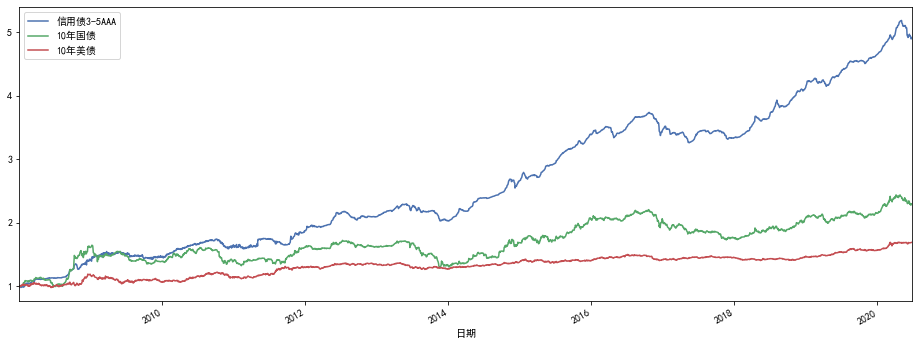

In [18]:
leverCumReturns[['信用债3-5AAA', '10年国债', '10年美债']].plot(figsize=(16, 6))

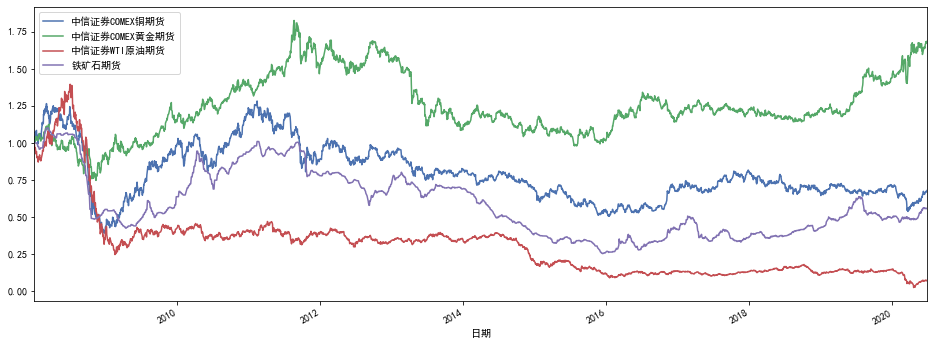

In [19]:
leverCumReturns[['中信证券COMEX铜期货', '中信证券COMEX黄金期货', '中信证券WTI原油期货', '铁矿石期货']].plot(figsize=(16, 6))

# 指数平均的效果

## 模型A：国内全资产（无指数平均）

In [20]:
leverReturns_A  = leverReturns.drop(['标普500', '10年美债'], axis=1)
leverCumReturns_A = leverCumReturns.drop(['标普500', '10年美债'], axis=1)

### 程序运行

In [21]:
tradeDF_A, weightDF_A = AlgoLoop.AlgoTrade(Assets, leverReturns_A, leverCumReturns_A, Turnovers, FXRates, mode='plain')

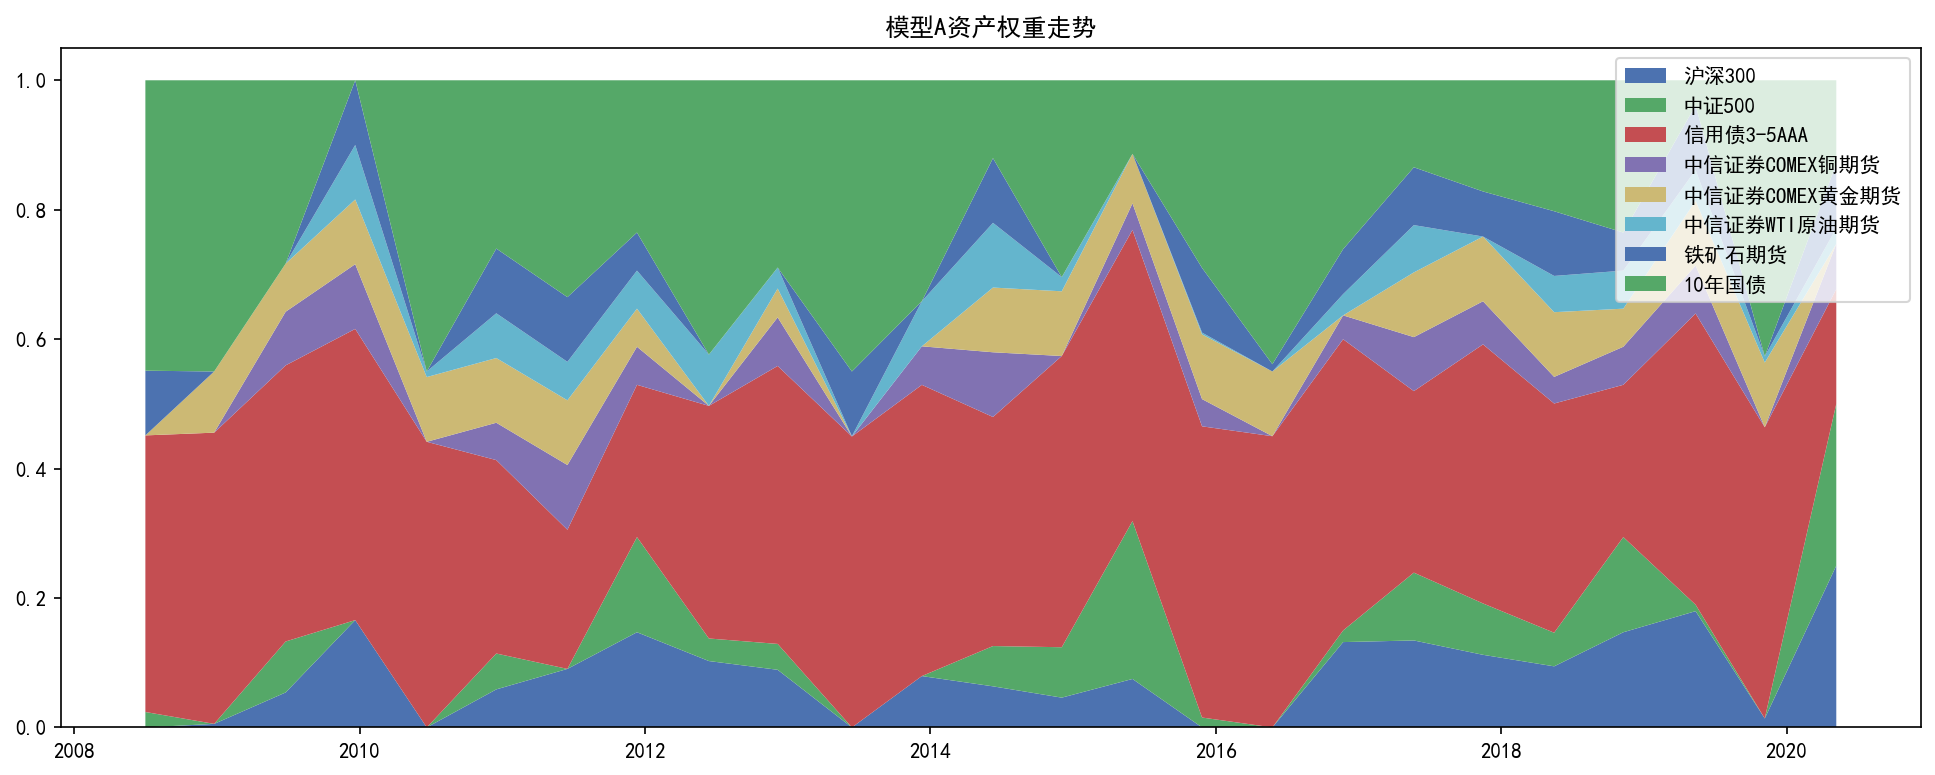

In [22]:
StatisticFunc.WeightPlot(tradeDF_A, weightDF_A, '模型A')

### 回测表现汇总

In [23]:
smryDF_A = StatisticFunc.summaryDF(tradeDF_A)
pfmcDF_A = StatisticFunc.performanceDF(smryDF_A, tradeDF_A, name='模型A')

In [24]:
smryDF_A

年收益率      年波动率       信息比      最大回撤
2008  0.328119  0.141612  2.317029 -0.043059
2009  0.040591  0.091118  0.445482 -0.062143
2010  0.029666  0.085468  0.347098 -0.119514
2011  0.034390  0.077713  0.442520 -0.128600
2012 -0.005209  0.061089 -0.085271 -0.093771
2013 -0.085408  0.061820 -1.381548 -0.171925
2014  0.159236  0.049161  3.239084 -0.169322
2015  0.106386  0.102789  1.034991 -0.121439
2016  0.115501  0.045960  2.513100 -0.083155
2017 -0.046907  0.041467 -1.131193 -0.126032
2018  0.060508  0.051989  1.163871 -0.089686
2019  0.147633  0.061919  2.384303 -0.050330
2020  0.135355  0.071873  1.883259 -0.033978

In [25]:
pfmcDF_A

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
模型A  0.078451  0.072614 -0.171925    1152.0  1.080388  0.456309

### 收益率贡献度

In [26]:
annualContrb_A = StatisticFunc.AnnualContribution(tradeDF_A)

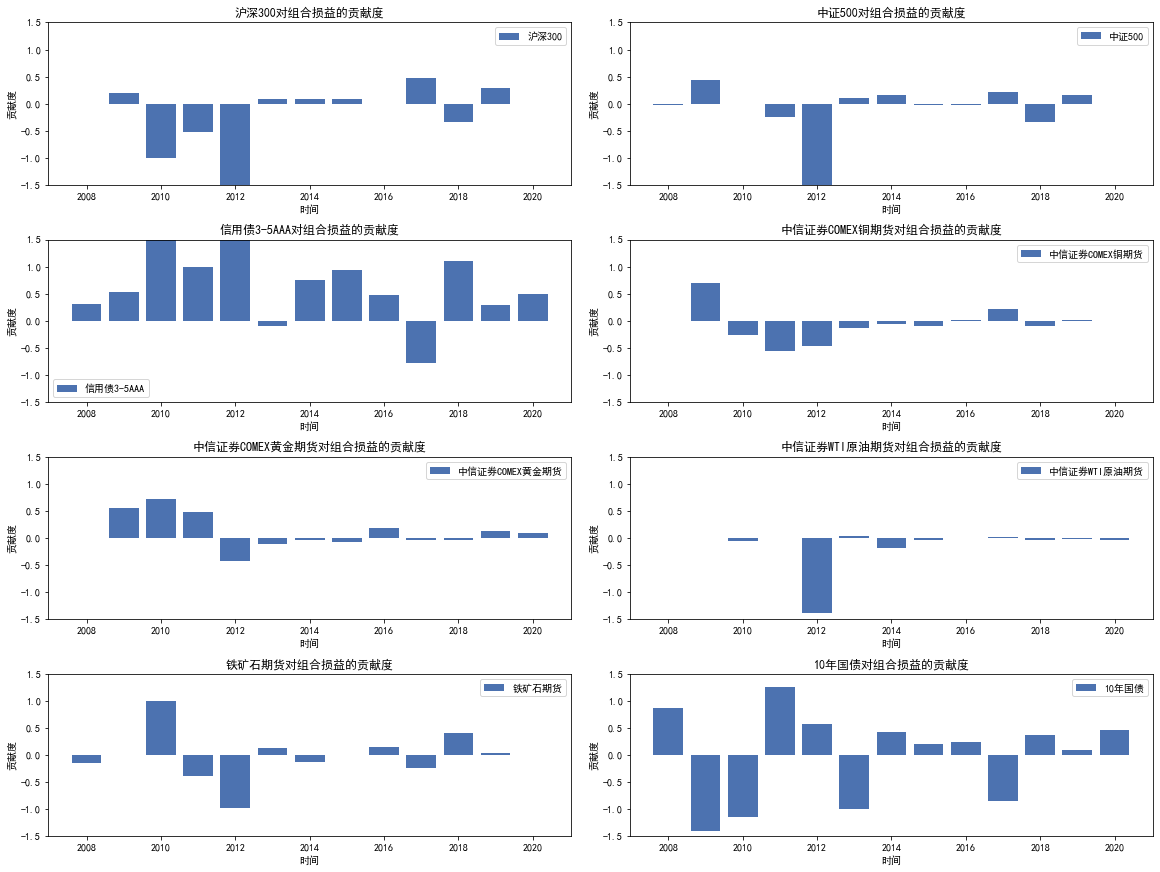

In [27]:
StatisticFunc.BarPlot(annualContrb_A, '模型A')

### 投资组合净值曲线

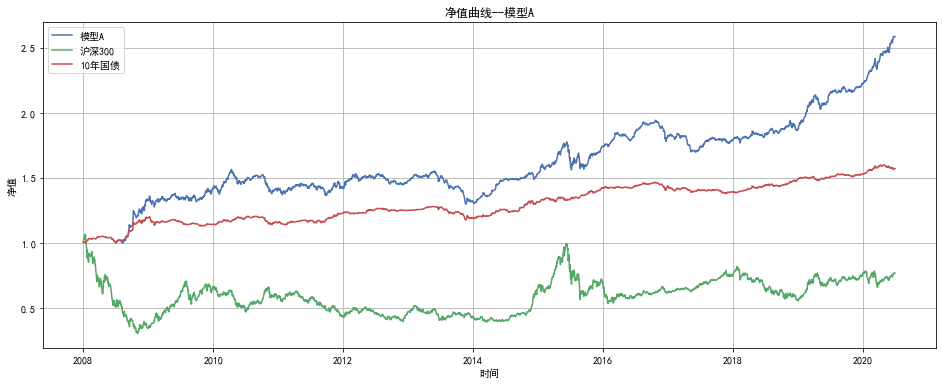

In [28]:
fig = plt.figure(figsize=(16, 6))

plt.plot(tradeDF_A.index, tradeDF_A['投资组合净值']/10000, label='模型A')
    
plt.plot(cumReturns.index, cumReturns['沪深300'], label='沪深300')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('净值曲线--模型A')
plt.savefig('Pics/净值曲线_模型A.png')

## 模型B：国内全资产（指数平均）

In [29]:
leverReturns_B  = leverReturns.drop(['标普500', '10年美债'], axis=1)
leverCumReturns_B = leverCumReturns.drop(['标普500', '10年美债'], axis=1)

### 程序运行

In [30]:
tradeDF_B, weightDF_B = AlgoLoop.AlgoTrade(Assets, leverReturns_B, leverCumReturns_B, Turnovers, FXRates, mode='ema')

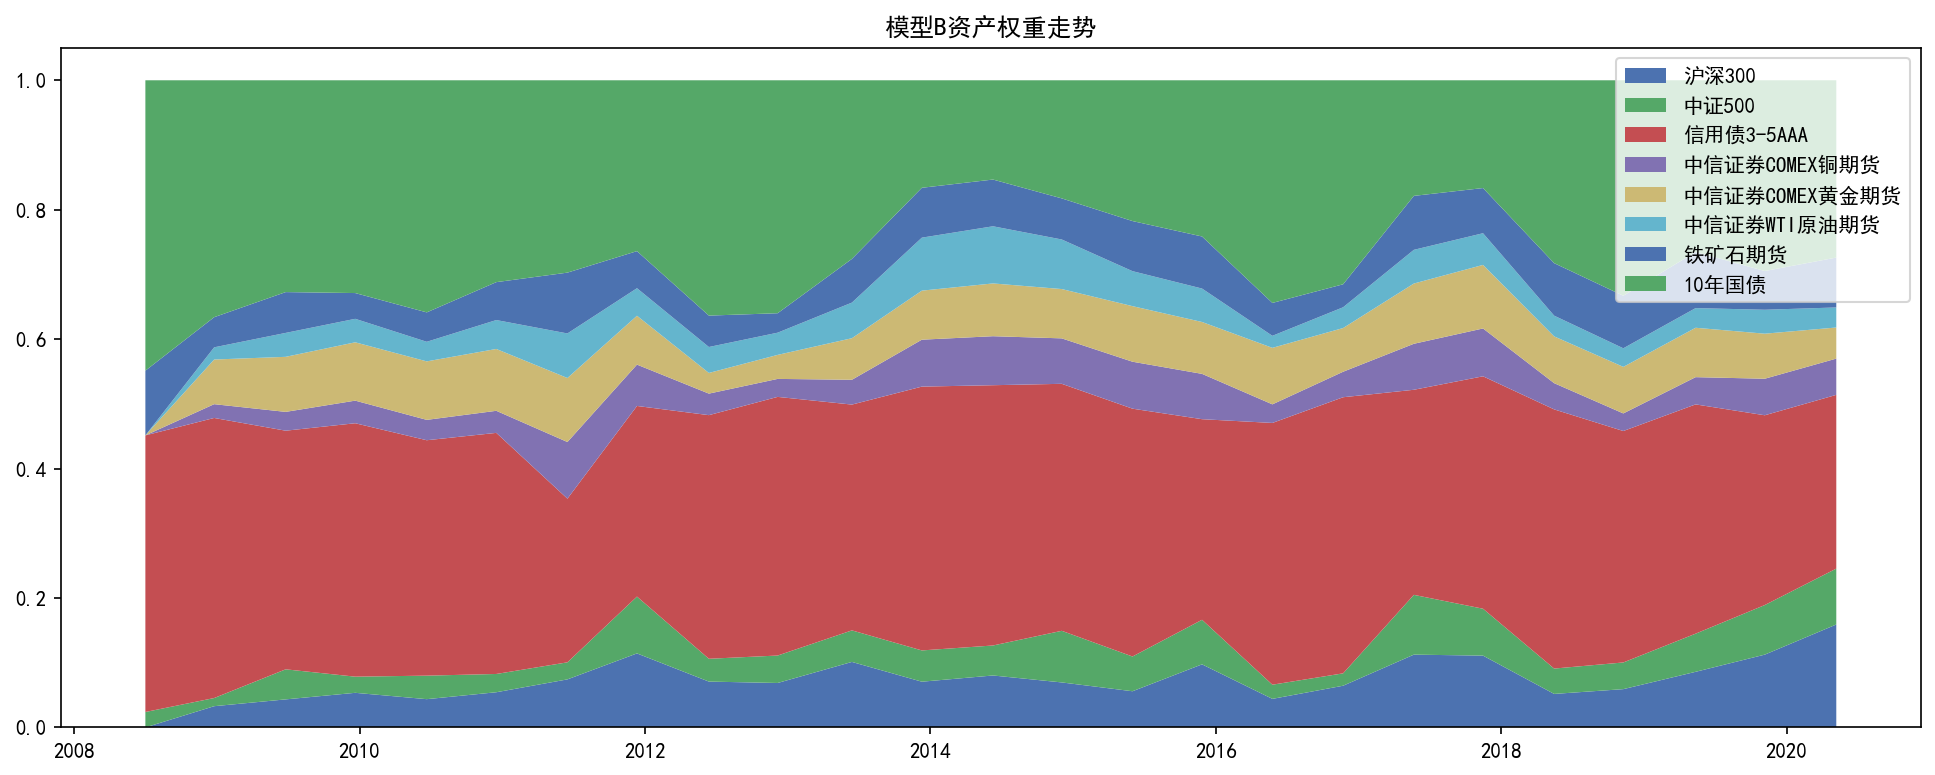

In [31]:
StatisticFunc.WeightPlot(tradeDF_B, weightDF_B, '模型B')

### 回测表现汇总

In [32]:
smryDF_B = StatisticFunc.summaryDF(tradeDF_B)
pfmcDF_B = StatisticFunc.performanceDF(smryDF_B, tradeDF_B, name='国内全资产（指数移动平均）')

In [33]:
smryDF_B

年收益率      年波动率       信息比      最大回撤
2008  0.328119  0.141936  2.311737 -0.043059
2009  0.074571  0.080739  0.923605 -0.049575
2010  0.110238  0.063805  1.727730 -0.067196
2011  0.042657  0.076292  0.559125 -0.072877
2012  0.009436  0.049449  0.190828 -0.050488
2013 -0.035843  0.057207 -0.626549 -0.119475
2014  0.127180  0.044274  2.872585 -0.122865
2015  0.119028  0.068222  1.744718 -0.048310
2016  0.089020  0.056338  1.580120 -0.073270
2017 -0.053162  0.039128 -1.358679 -0.108463
2018  0.088277  0.042943  2.055663 -0.077690
2019  0.116624  0.036584  3.187818 -0.026203
2020  0.068784  0.072110  0.953882 -0.057292

In [34]:
pfmcDF_B

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
国内全资产（指数移动平均）  0.083456  0.063771 -0.122865     425.0  1.308679   0.67925

### 收益率贡献度

In [35]:
annualContrb_B = StatisticFunc.AnnualContribution(tradeDF_B)

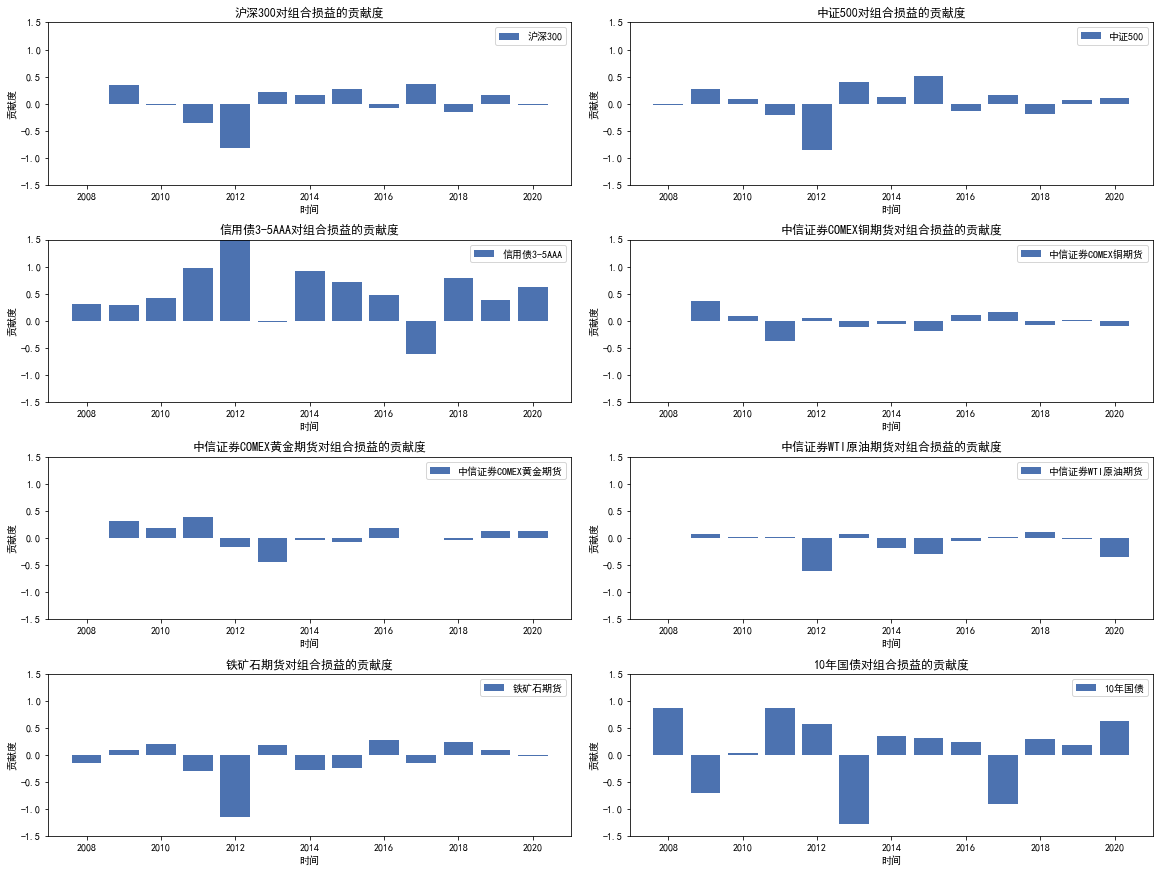

In [36]:
StatisticFunc.BarPlot(annualContrb_B, '模型B')

### 投资组合净值曲线

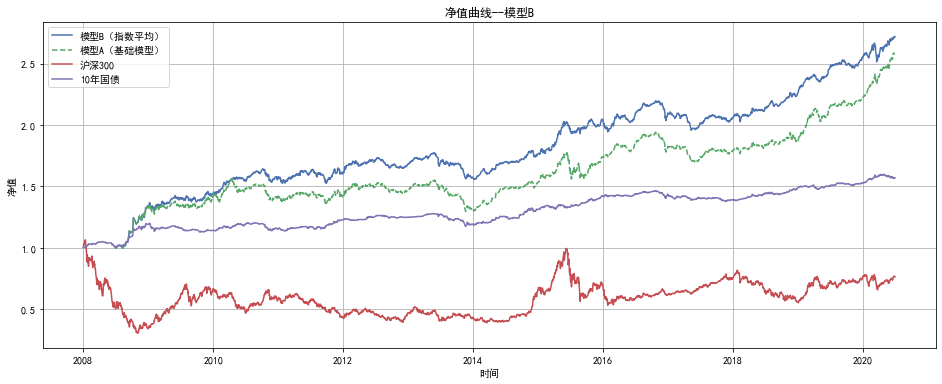

In [37]:
fig = plt.figure(figsize=(16, 6))

plt.plot(tradeDF_B.index, tradeDF_B['投资组合净值']/10000, label='模型B（指数平均）')
    
plt.plot(tradeDF_A.index, tradeDF_A['投资组合净值']/10000, ls='--', label='模型A（基础模型）')  
plt.plot(cumReturns.index, cumReturns['沪深300'], label='沪深300')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('净值曲线--模型B')
plt.savefig('Pics/净值曲线_模型B.png')

# 各类资产的特性与选择

- 有商品期货
- 无商品期货

## 各资产的年度表现

### 年化收益

In [38]:
# annualR = StatisticFunc.AnnualReturns(cumReturns)
# annualR

### 年化波动率

In [39]:
# annualV = StatisticFunc.AnnualVolatility(cumReturns)
# annualV

### 汇总

In [40]:
# annualDF = pd.DataFrame(index=['年化收益', '年化波动率', '信息比'], columns=annualR.columns)
# annualDF.loc['年化收益', :] = annualR.mean(axis=0)
# annualDF.loc['年化波动率', :] = annualV.mean(axis=0)
# annualDF.loc['信息比', :] = annualDF.loc['年化收益', :] / annualDF.loc['年化波动率', :]

In [41]:
# annualDF

## 模型C：剔除部分商品期货

In [42]:
# 仅保留黄金期货
leverReturns_C1    = leverReturns_B.drop(['中信证券COMEX铜期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)
leverCumReturns_C1 = leverCumReturns_B.drop(['中信证券COMEX铜期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)

# 仅保留铁矿石期货
leverReturns_C2    = leverReturns_B.drop(['中信证券COMEX铜期货', '中信证券COMEX黄金期货', '中信证券WTI原油期货'], axis=1)
leverCumReturns_C2 = leverCumReturns_B.drop(['中信证券COMEX铜期货', '中信证券COMEX黄金期货', '中信证券WTI原油期货'], axis=1)

# 保留黄金和铁矿石
leverReturns_C3    = leverReturns_B.drop(['中信证券COMEX黄金期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)
leverCumReturns_C3 = leverCumReturns_B.drop(['中信证券COMEX黄金期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)

# 剔除所有商品期货
leverReturns_C4    = leverReturns_B.drop(['中信证券COMEX铜期货', '中信证券COMEX黄金期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)
leverCumReturns_C4 = leverCumReturns_B.drop(['中信证券COMEX铜期货', '中信证券COMEX黄金期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)

### 程序运行

In [43]:
tradeDF_C1, weightDF_C1 = AlgoLoop.AlgoTrade(Assets, leverReturns_C1, leverCumReturns_C1, 
                                             Turnovers, FXRates, mode='ema')
tradeDF_C2, weightDF_C2 = AlgoLoop.AlgoTrade(Assets, leverReturns_C2, leverCumReturns_C2, 
                                             Turnovers, FXRates, mode='ema')
tradeDF_C3, weightDF_C3 = AlgoLoop.AlgoTrade(Assets, leverReturns_C3, leverCumReturns_C3, 
                                             Turnovers, FXRates, mode='ema')
tradeDF_C4, weightDF_C4 = AlgoLoop.AlgoTrade(Assets, leverReturns_C4, leverCumReturns_C4, 
                                             Turnovers, FXRates, mode='ema')

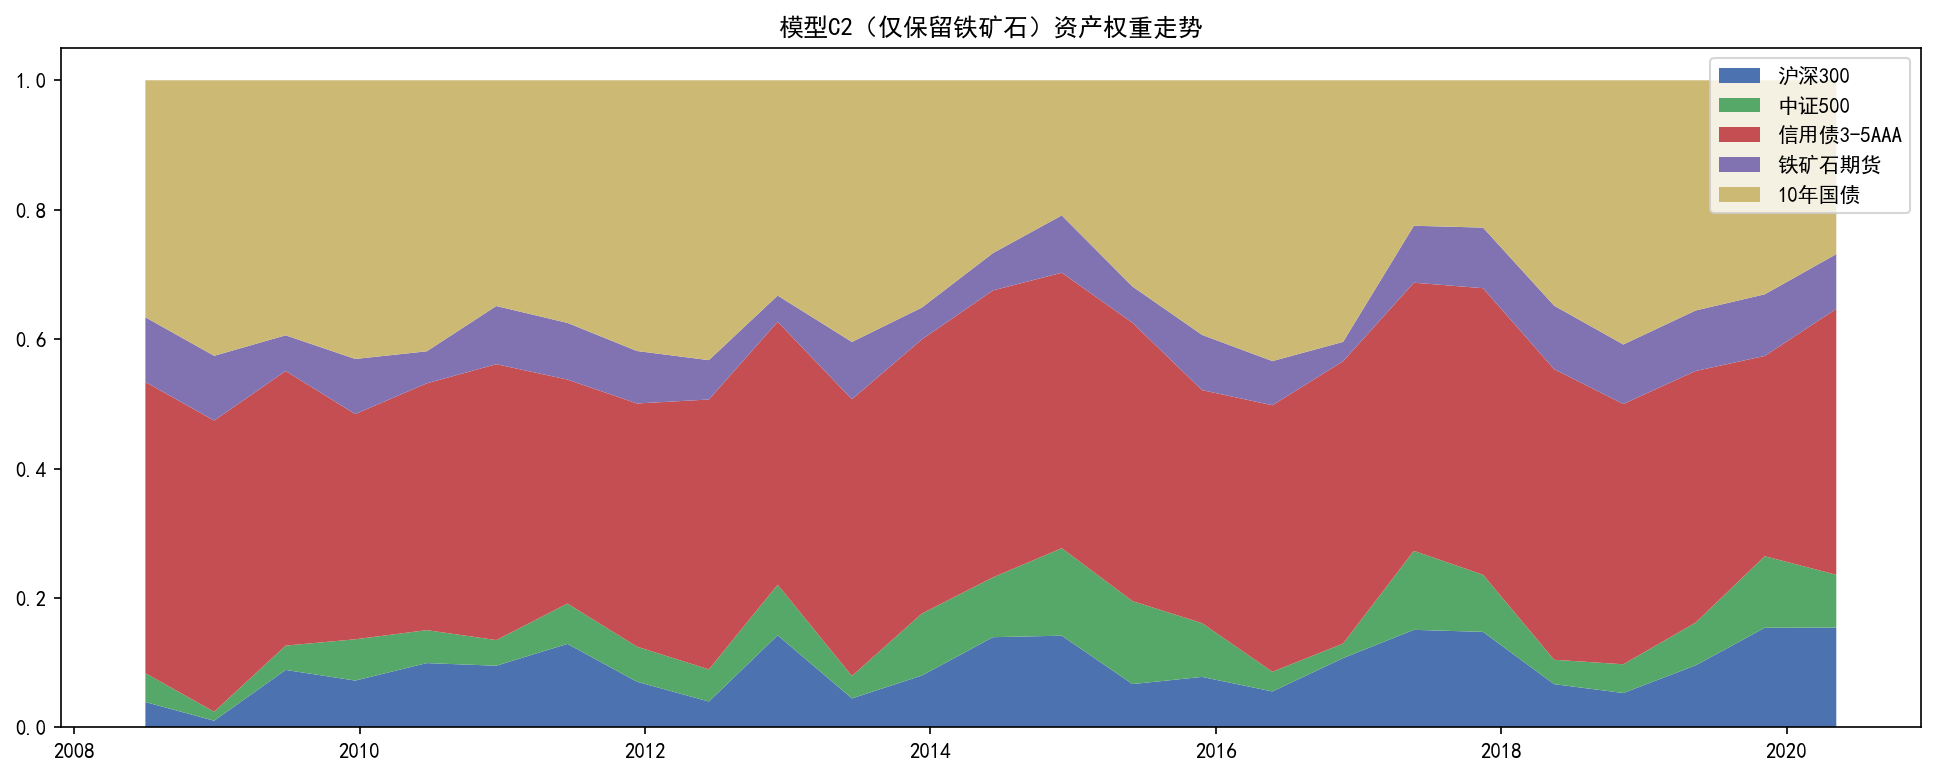

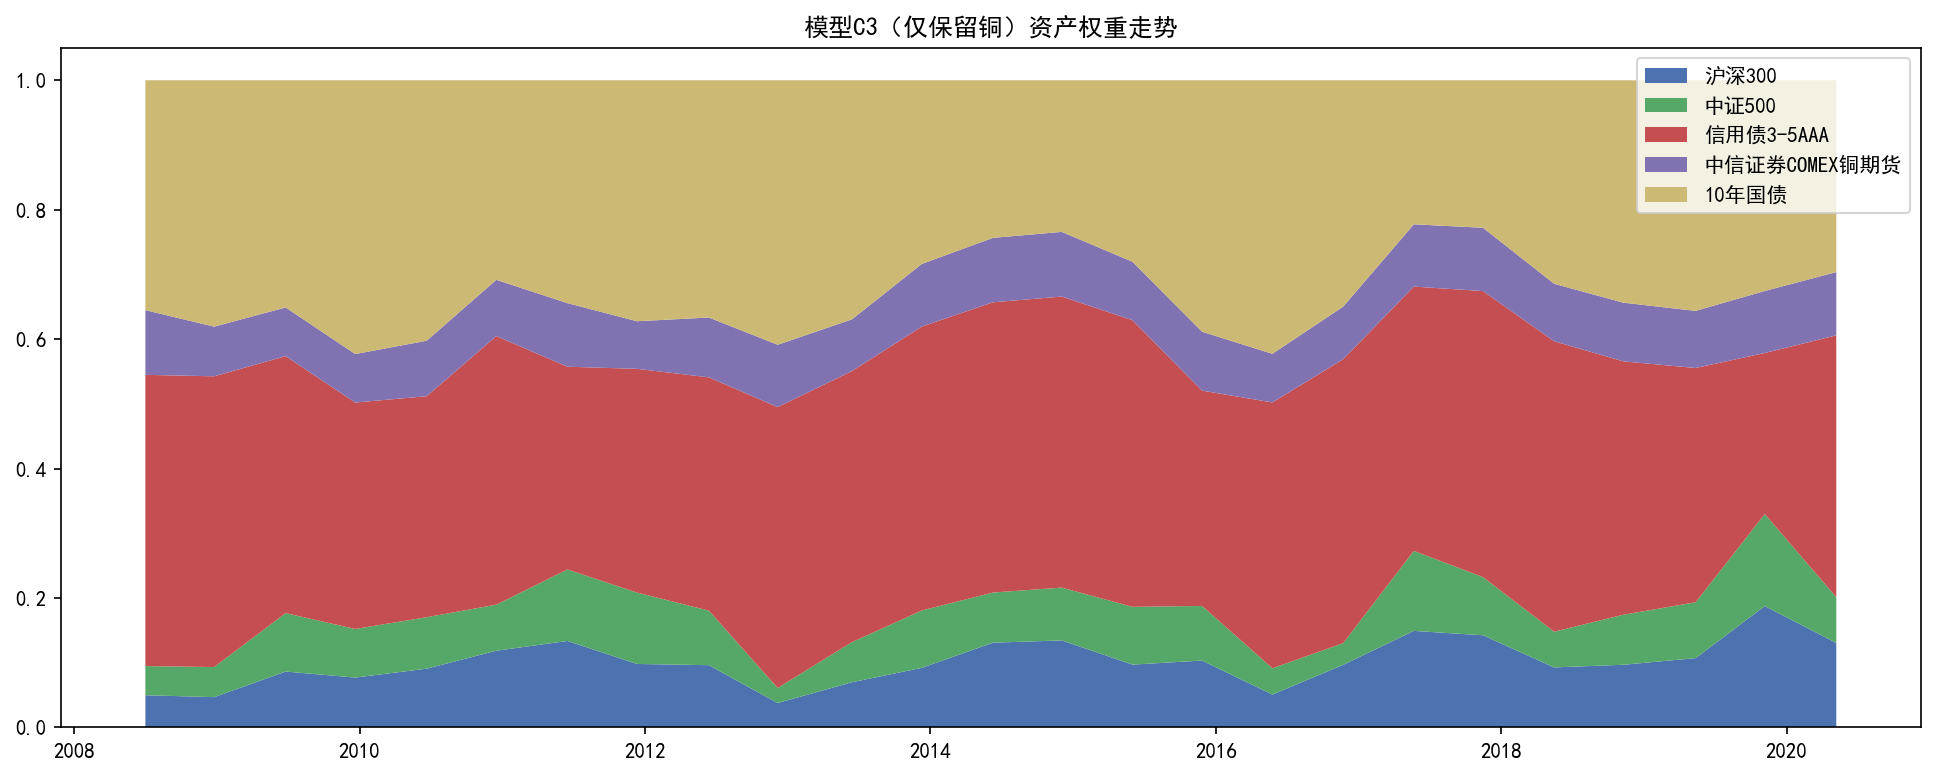

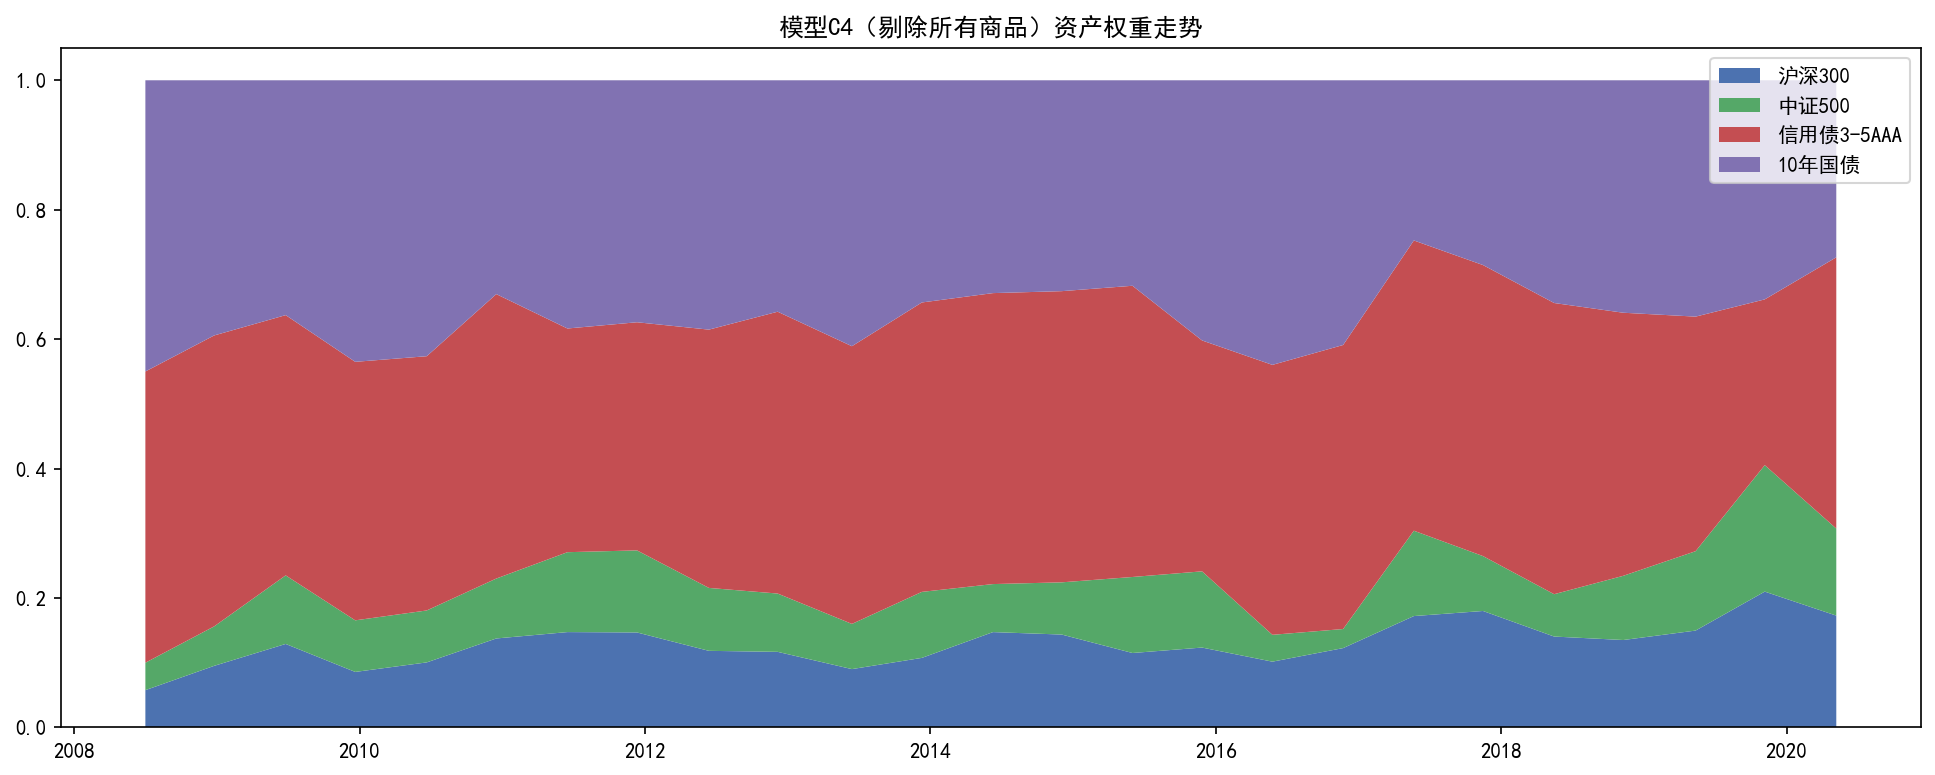

In [44]:
StatisticFunc.WeightPlot(tradeDF_C1, weightDF_C1, '模型C1（仅保留黄金）')
StatisticFunc.WeightPlot(tradeDF_C2, weightDF_C2, '模型C2（仅保留铁矿石）')
StatisticFunc.WeightPlot(tradeDF_C3, weightDF_C3, '模型C3（仅保留铜）')
StatisticFunc.WeightPlot(tradeDF_C4, weightDF_C4, '模型C4（剔除所有商品）')

### 回测表现汇总

In [45]:
smryDF_C1 = StatisticFunc.summaryDF(tradeDF_C1)
pfmcDF_C1 = StatisticFunc.performanceDF(smryDF_C1, tradeDF_C1, name='模型C1（仅保留黄金）')

smryDF_C2 = StatisticFunc.summaryDF(tradeDF_C2)
pfmcDF_C2 = StatisticFunc.performanceDF(smryDF_C2, tradeDF_C2, name='模型C2（仅保留铁矿石）')

smryDF_C3 = StatisticFunc.summaryDF(tradeDF_C3)
pfmcDF_C3 = StatisticFunc.performanceDF(smryDF_C3, tradeDF_C3, name='模型C3（仅保留铜）')

smryDF_C4 = StatisticFunc.summaryDF(tradeDF_C4)
pfmcDF_C4 = StatisticFunc.performanceDF(smryDF_C4, tradeDF_C4, name='模型C4（剔除所有商品）')

In [46]:
# 仅保留黄金
smryDF_C1

年收益率      年波动率       信息比      最大回撤
2008  0.134425  0.166786  0.805971 -0.102252
2009  0.074447  0.088260  0.843497 -0.055240
2010  0.081314  0.066005  1.231948 -0.074328
2011  0.064464  0.076467  0.843023 -0.092203
2012  0.032767  0.045690  0.717165 -0.051353
2013 -0.086003  0.063540 -1.353527 -0.150207
2014  0.264745  0.057486  4.605415 -0.154190
2015  0.279066  0.079875  3.493773 -0.056014
2016  0.072033  0.057667  1.249118 -0.100811
2017 -0.054693  0.040574 -1.347979 -0.126786
2018  0.067683  0.041777  1.620108 -0.102190
2019  0.117508  0.036167  3.249040 -0.036428
2020  0.112487  0.075769  1.484608 -0.051159

In [47]:
# 仅保留铁矿石
smryDF_C2

年收益率      年波动率       信息比      最大回撤
2008  0.264046  0.131705  2.004833 -0.048262
2009 -0.009728  0.079794 -0.121917 -0.063316
2010  0.103945  0.067750  1.534250 -0.074894
2011  0.044157  0.075764  0.582826 -0.083500
2012  0.030407  0.042483  0.715740 -0.066008
2013 -0.043201  0.064894 -0.665717 -0.156808
2014  0.267199  0.062323  4.287315 -0.158682
2015  0.295843  0.088419  3.345907 -0.061825
2016  0.088796  0.056988  1.558146 -0.086763
2017 -0.064097  0.042130 -1.521416 -0.122992
2018  0.107136  0.039716  2.697533 -0.086062
2019  0.114353  0.036729  3.113438 -0.029803
2020  0.101132  0.063203  1.600107 -0.041412

In [48]:
# 仅保留铜
smryDF_C3

年收益率      年波动率       信息比      最大回撤
2008  0.233796  0.129886  1.800017 -0.045194
2009  0.146862  0.099768  1.472039 -0.048633
2010  0.097769  0.075275  1.298820 -0.069872
2011  0.013664  0.084921  0.160900 -0.096293
2012  0.030481  0.052524  0.580323 -0.057299
2013 -0.067234  0.062535 -1.075142 -0.144149
2014  0.259579  0.057720  4.497228 -0.142393
2015  0.236138  0.082123  2.875403 -0.060718
2016  0.074898  0.059713  1.254313 -0.081921
2017 -0.039341  0.042500 -0.925665 -0.113339
2018  0.057561  0.049220  1.169461 -0.077456
2019  0.113676  0.046125  2.464523 -0.041173
2020  0.084122  0.086646  0.970860 -0.061082

In [49]:
# 剔除所有商品
smryDF_C4

年收益率      年波动率       信息比      最大回撤
2008  0.360453  0.141751  2.542855 -0.036316
2009  0.106383  0.101874  1.044255 -0.063377
2010  0.078904  0.071214  1.107983 -0.082548
2011  0.033311  0.086702  0.384200 -0.099340
2012  0.018864  0.057260  0.329445 -0.067784
2013 -0.045934  0.071309 -0.644155 -0.161793
2014  0.298055  0.064043  4.653983 -0.164244
2015  0.265424  0.088749  2.990731 -0.070958
2016  0.052035  0.066002  0.788375 -0.099062
2017 -0.053339  0.043165 -1.235685 -0.130803
2018  0.061214  0.048780  1.254900 -0.097523
2019  0.128151  0.053814  2.381393 -0.045503
2020  0.103652  0.089692  1.155648 -0.057603

In [50]:
tmp = pd.concat([pfmcDF_C1, pfmcDF_C2, pfmcDF_C3, pfmcDF_C4])
tmp

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
模型C1（仅保留黄金）   0.089249  0.068928 -0.154190     517.0  1.294823  0.578827
模型C2（仅保留铁矿石）  0.099999  0.065531 -0.158682     488.0  1.525991  0.630186
模型C3（仅保留铜）    0.095536  0.071458 -0.144149     488.0  1.336951  0.662760
模型C4（剔除所有商品）  0.108244  0.075720 -0.164244     517.0  1.429538  0.659045

### 收益率贡献度

In [51]:
annualContrb_C1 = StatisticFunc.AnnualContribution(tradeDF_C1)

annualContrb_C2 = StatisticFunc.AnnualContribution(tradeDF_C2)

annualContrb_C3 = StatisticFunc.AnnualContribution(tradeDF_C3)

annualContrb_C4 = StatisticFunc.AnnualContribution(tradeDF_C4)

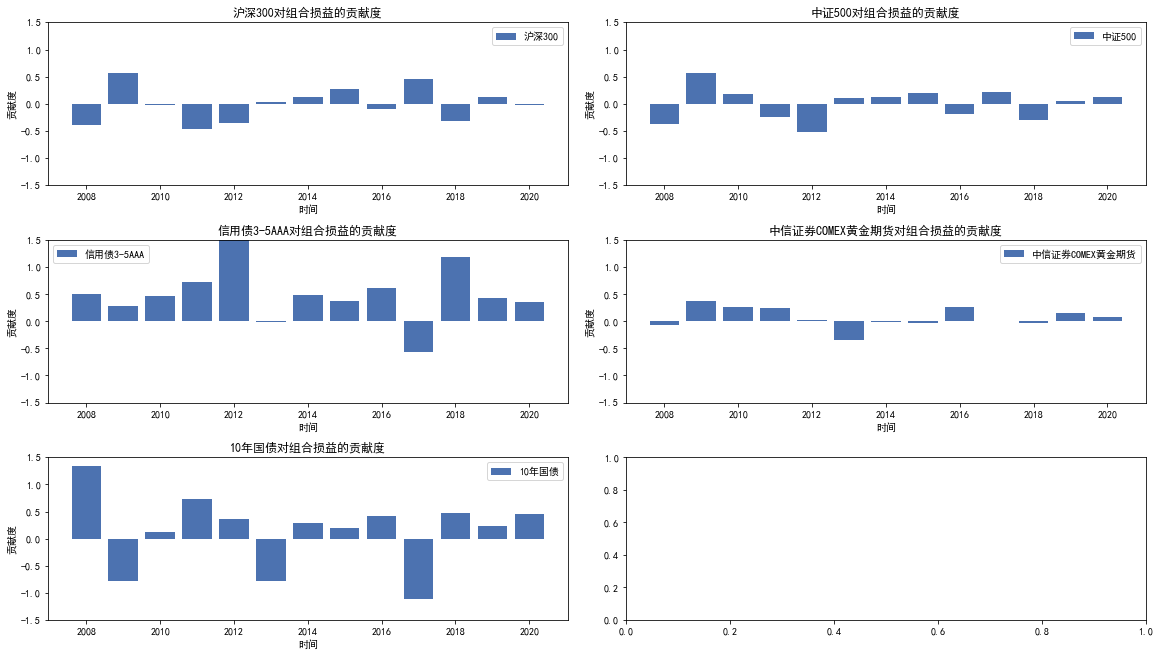

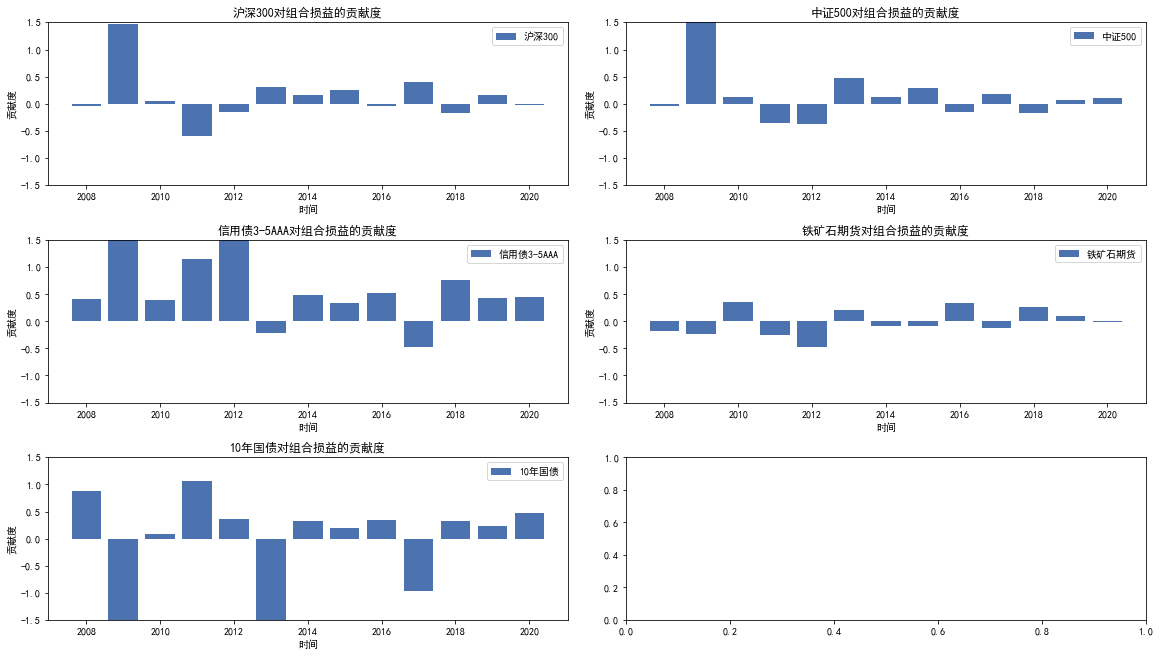

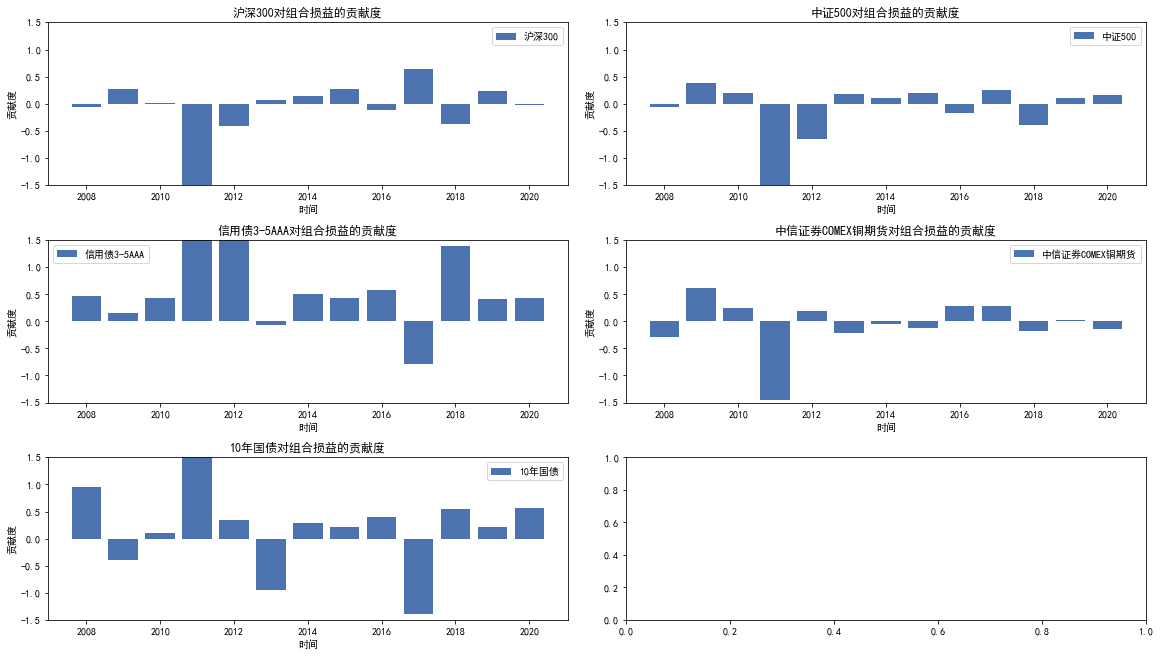

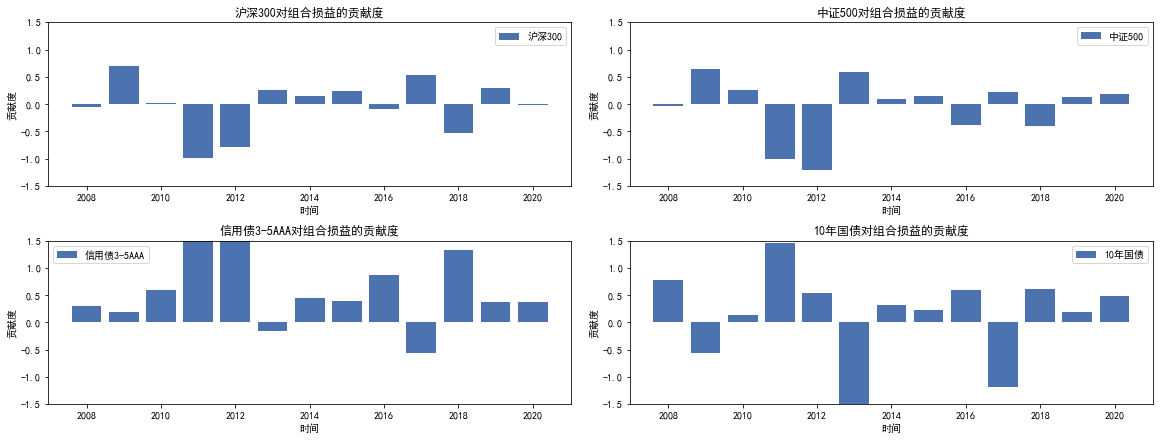

In [52]:
StatisticFunc.BarPlot(annualContrb_C1, '模型C1（仅保留黄金）')
StatisticFunc.BarPlot(annualContrb_C2, '模型C2（仅保留铁矿石）')
StatisticFunc.BarPlot(annualContrb_C3, '模型C3（仅保留铜）')
StatisticFunc.BarPlot(annualContrb_C4, '模型C4（剔除所有商品期货）')

### 投资组合净值曲线

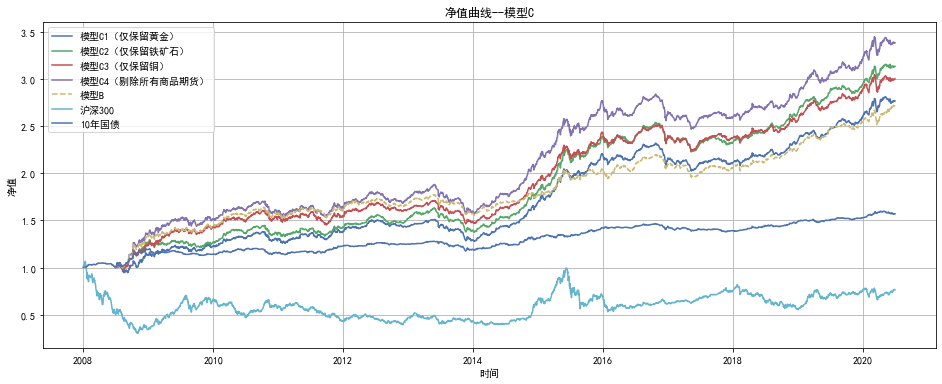

In [53]:
fig = plt.figure(figsize=(16, 6))

plt.plot(tradeDF_C1.index, tradeDF_C1['投资组合净值']/10000, label='模型C1（仅保留黄金）')
plt.plot(tradeDF_C2.index, tradeDF_C2['投资组合净值']/10000, label='模型C2（仅保留铁矿石）')
plt.plot(tradeDF_C3.index, tradeDF_C3['投资组合净值']/10000, label='模型C3（仅保留铜）')
plt.plot(tradeDF_C4.index, tradeDF_C4['投资组合净值']/10000, label='模型C4（剔除所有商品期货）')
    
plt.plot(tradeDF_B.index, tradeDF_B['投资组合净值']/10000, ls='--', label='模型B')  
plt.plot(cumReturns.index, cumReturns['沪深300'], label='沪深300')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('净值曲线--模型C')
plt.savefig('Pics/净值曲线_模型C.png')

# 资产分散的效果

## 各资产间相关性

In [54]:
corrDF = cumReturns.corr()
corrDF

沪深300     中证500  信用债3-5AAA  中信证券COMEX铜期货  中信证券COMEX黄金期货  \
沪深300          1.000000  0.758996   0.455760     -0.082924      -0.069710   
中证500          0.758996  1.000000   0.573525     -0.315036      -0.051980   
信用债3-5AAA      0.455760  0.573525   1.000000     -0.617814       0.191166   
中信证券COMEX铜期货  -0.082924 -0.315036  -0.617814      1.000000       0.310878   
中信证券COMEX黄金期货 -0.069710 -0.051980   0.191166      0.310878       1.000000   
中信证券WTI原油期货   -0.225709 -0.524662  -0.768984      0.661697      -0.254673   
标普500          0.541116  0.564017   0.949736     -0.474607       0.113409   
铁矿石期货         -0.268238 -0.536481  -0.687471      0.876541       0.295797   
10年国债          0.421037  0.556464   0.984725     -0.667222       0.215692   
10年美债          0.329452  0.526424   0.948543     -0.593492       0.375001   

               中信证券WTI原油期货     标普500     铁矿石期货     10年国债     10年美债  
沪深300            -0.225709  0.541116 -0.268238  0.421037  0.329452  
中证500            -0.524662  0.564017 -0.536481  0.556464  0.526424  
信用债3-5AAA        -0.768984  0.949736 -0.687471  0.984725  0.948543  
中信证券COMEX铜期货      0.661697 -0.474607  0.876541 -0.667222 -0.593492  
中信证券COMEX黄金期货    -0.254673  0.113409  0.295797  0.215692  0.375001  
中信证券WTI原油期货       1.000000 -0.600452  0.745517 -0.816450 -0.795606  
标普500            -0.600452  1.000000 -0.580541  0.892710  0.866378  
铁矿石期货             0.745517 -0.580541  1.000000 -0.716660 -0.634934  
10年国债            -0.816450  0.892710 -0.716660  1.000000  0.947366  
10年美债            -0.795606  0.866378 -0.634934  0.947366  1.000000

In [55]:
fig = plt.figure(figsize=(10, 10), dpi=200)
sns.heatmap(corrDF, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

## 模型D：引入美元资产

- 标普500
- 10年期美债

In [56]:
leverReturns_D    = leverReturns.drop(['中信证券COMEX铜期货', '中信证券COMEX黄金期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)
leverCumReturns_D = leverCumReturns.drop(['中信证券COMEX铜期货', '中信证券COMEX黄金期货', '铁矿石期货', '中信证券WTI原油期货'], axis=1)

### 程序运行

In [57]:
tradeDF_D, weightDF_D = AlgoLoop.AlgoTrade(Assets, leverReturns_D, leverCumReturns_D, Turnovers, FXRates, mode='ema')

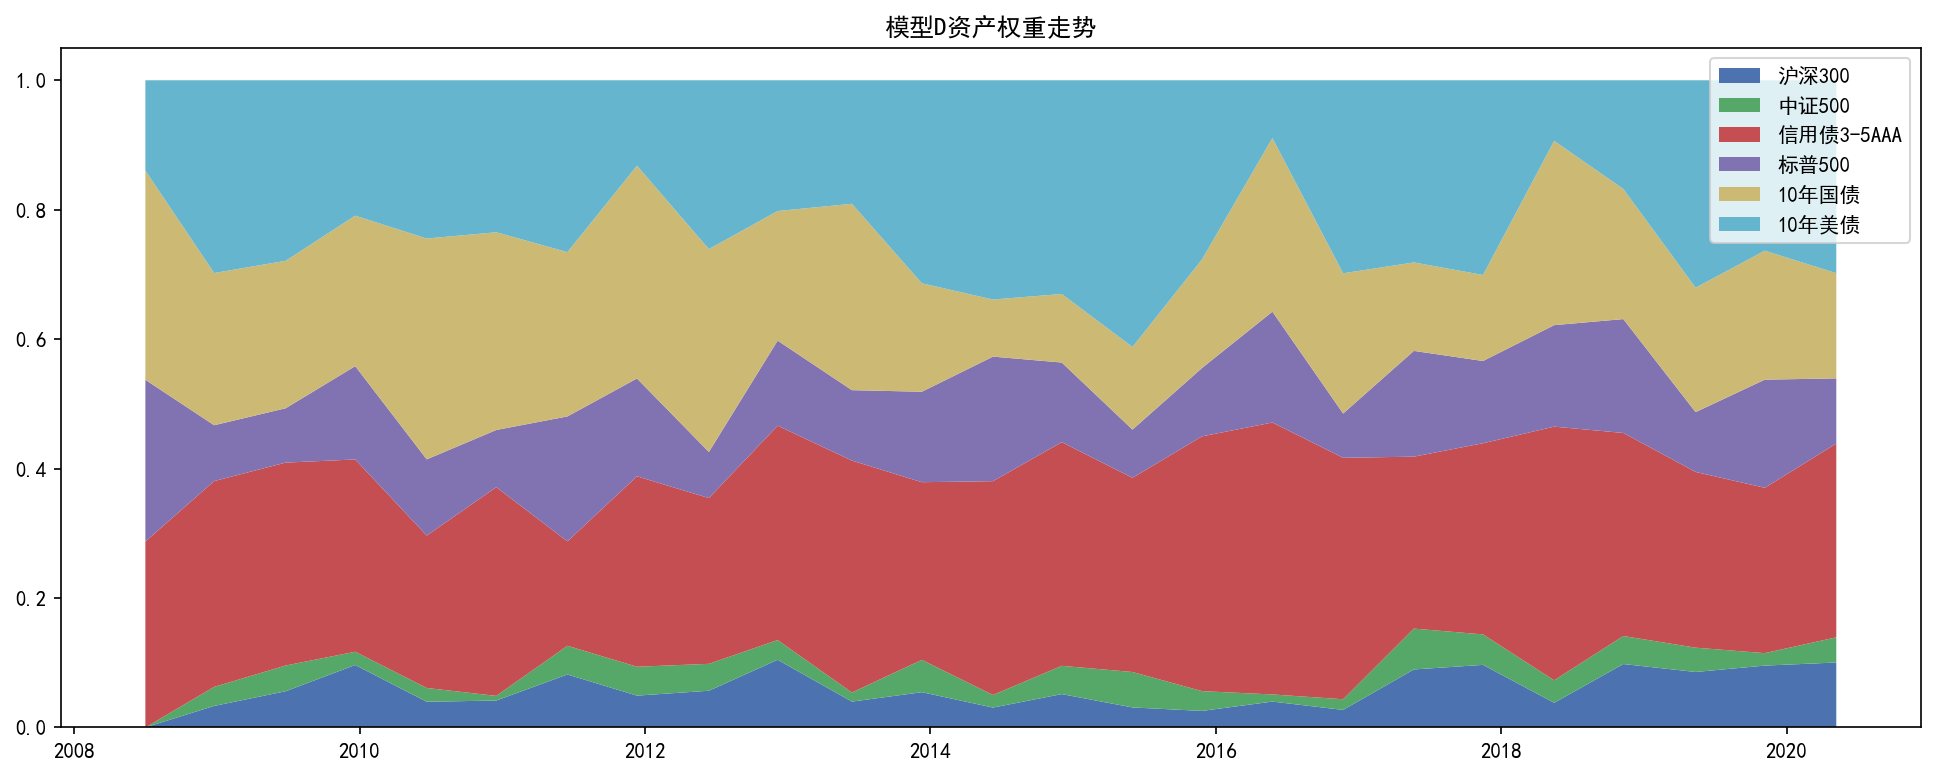

In [58]:
StatisticFunc.WeightPlot(tradeDF_D, weightDF_D, '模型D')

### 回测表现汇总

In [59]:
smryDF_D = StatisticFunc.summaryDF(tradeDF_D)
pfmcDF_D = StatisticFunc.performanceDF(smryDF_D, tradeDF_D, name='模型D')

In [60]:
smryDF_D

年收益率      年波动率       信息比      最大回撤
2008  0.217568  0.122966  1.769333 -0.041150
2009  0.036328  0.065437  0.555158 -0.043200
2010  0.052929  0.051411  1.029514 -0.069906
2011  0.070809  0.063259  1.119362 -0.080828
2012  0.057838  0.035499  1.629285 -0.038664
2013 -0.025055  0.050538 -0.495775 -0.120275
2014  0.179209  0.034071  5.259902 -0.119632
2015  0.157518  0.043930  3.585630 -0.031621
2016  0.076300  0.035836  2.129172 -0.069208
2017 -0.018099  0.026041 -0.695039 -0.081003
2018  0.066310  0.037682  1.759727 -0.055355
2019  0.122422  0.033952  3.605676 -0.024006
2020  0.074126  0.073104  1.013968 -0.055368

In [61]:
pfmcDF_D

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
模型D  0.082169  0.051825 -0.120275     421.0  1.585513  0.683176

### 收益率贡献度

In [62]:
annualContrb_D = StatisticFunc.AnnualContribution(tradeDF_D)

In [63]:
StatisticFunc.BarPlot(annualContrb_D, '模型D')

### 投资组合净值曲线

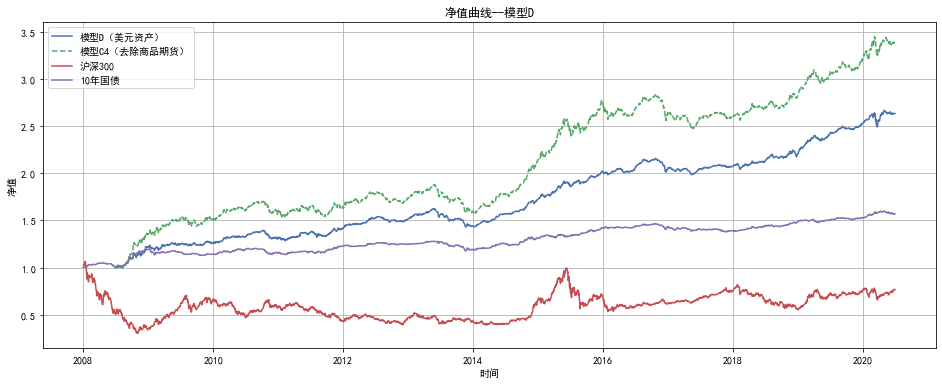

In [64]:
fig = plt.figure(figsize=(16, 6))

plt.plot(tradeDF_D.index, tradeDF_D['投资组合净值']/10000, label='模型D（美元资产）')
    
plt.plot(tradeDF_C4.index, tradeDF_C4['投资组合净值']/10000, ls='--', label='模型C4（去除商品期货）')  
plt.plot(cumReturns.index, cumReturns['沪深300'], label='沪深300')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('净值曲线--模型D')
plt.savefig('Pics/净值曲线_模型D.png')

# 单因子和多因子的作用

## 模型E：单因子

- 横截面动量

### 程序运行

In [65]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':False, 'fxRate':False,
            'copperGold':False, 'copperGas':False}

tradeDF_single, weightDF_single = AlgoLoop.AlgoTrade(Assets, leverReturns_D, leverCumReturns_D, 
                                                     Turnovers, FXRates, mode='ema', dt=120, up=0.50, 
                                                     thresholds=thrds, factorDict=factors)

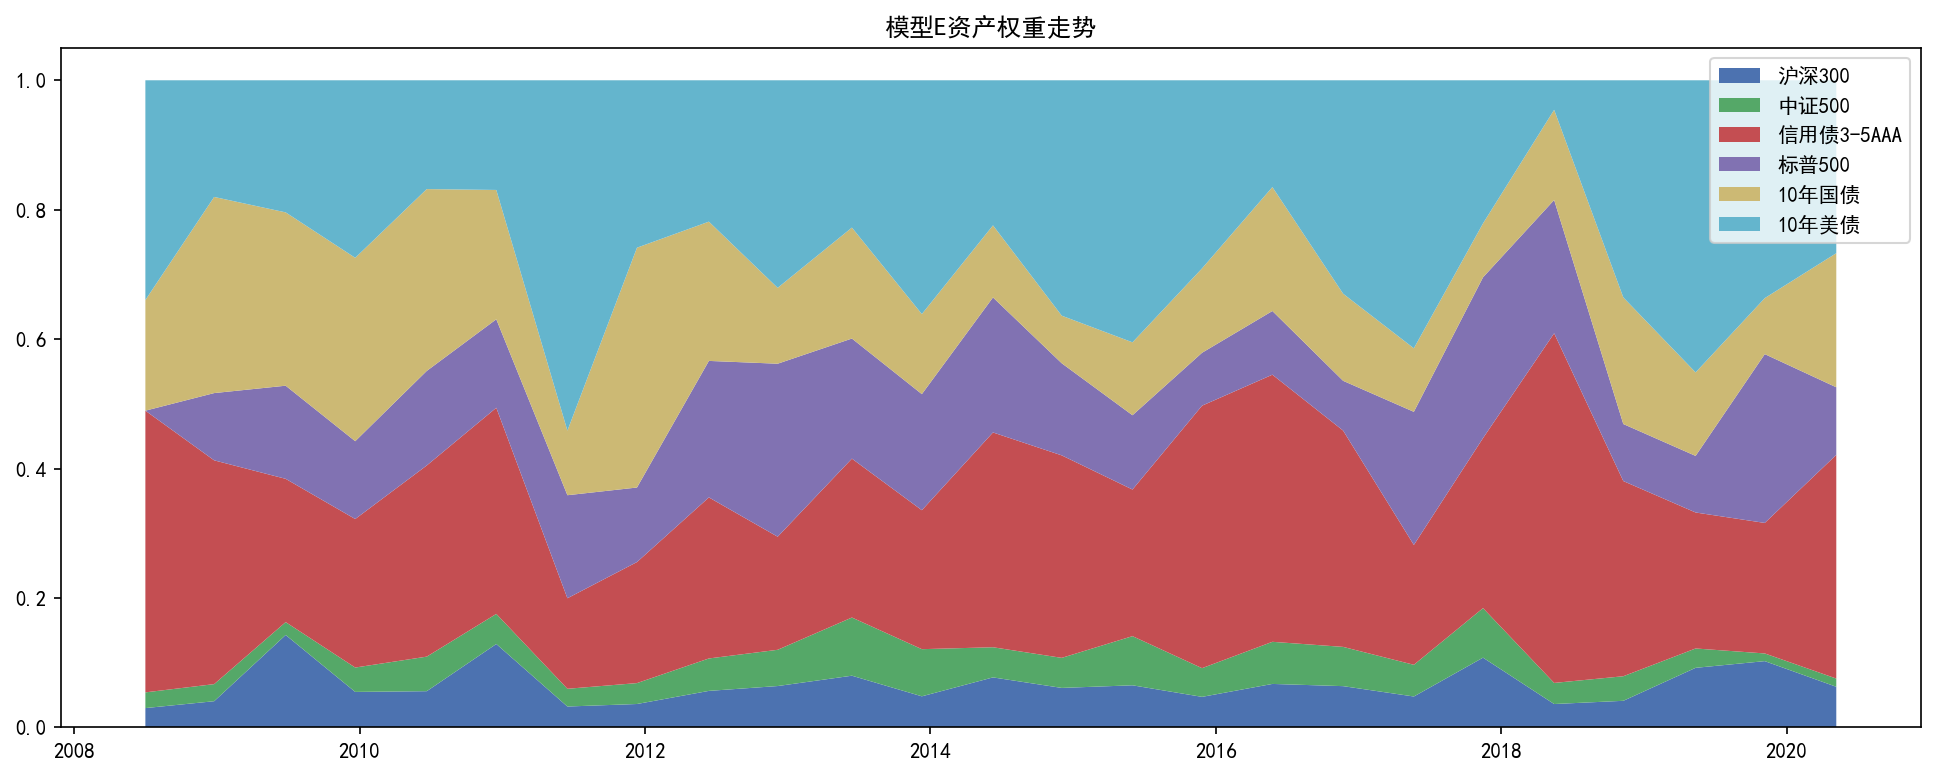

In [66]:
StatisticFunc.WeightPlot(tradeDF_single, weightDF_single, '模型E')

### 回测表现汇总

In [67]:
smryDF_single = StatisticFunc.summaryDF(tradeDF_single)
pfmcDF_single = StatisticFunc.performanceDF(smryDF_single, tradeDF_single, name='模型E')

In [68]:
smryDF_single

年收益率      年波动率       信息比      最大回撤
2008  0.253988  0.100881  2.517699 -0.029079
2009  0.061503  0.075925  0.810059 -0.050367
2010  0.078398  0.052871  1.482823 -0.060817
2011  0.062991  0.057867  1.088551 -0.066131
2012  0.054530  0.036230  1.505097 -0.030460
2013  0.032235  0.053416  0.603475 -0.070793
2014  0.194876  0.036656  5.316420 -0.072111
2015  0.135009  0.055399  2.437030 -0.048827
2016  0.073543  0.037483  1.962040 -0.062618
2017 -0.014382  0.025801 -0.557412 -0.070873
2018  0.078348  0.043982  1.781366 -0.052224
2019  0.117248  0.026903  4.358132 -0.018856
2020  0.047147  0.105919  0.445127 -0.086333

In [69]:
pfmcDF_single

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
模型E  0.090418  0.054564 -0.086333     417.0  1.657103  1.047316

### 收益率贡献度

In [70]:
annualContrb_single = StatisticFunc.AnnualContribution(tradeDF_single)

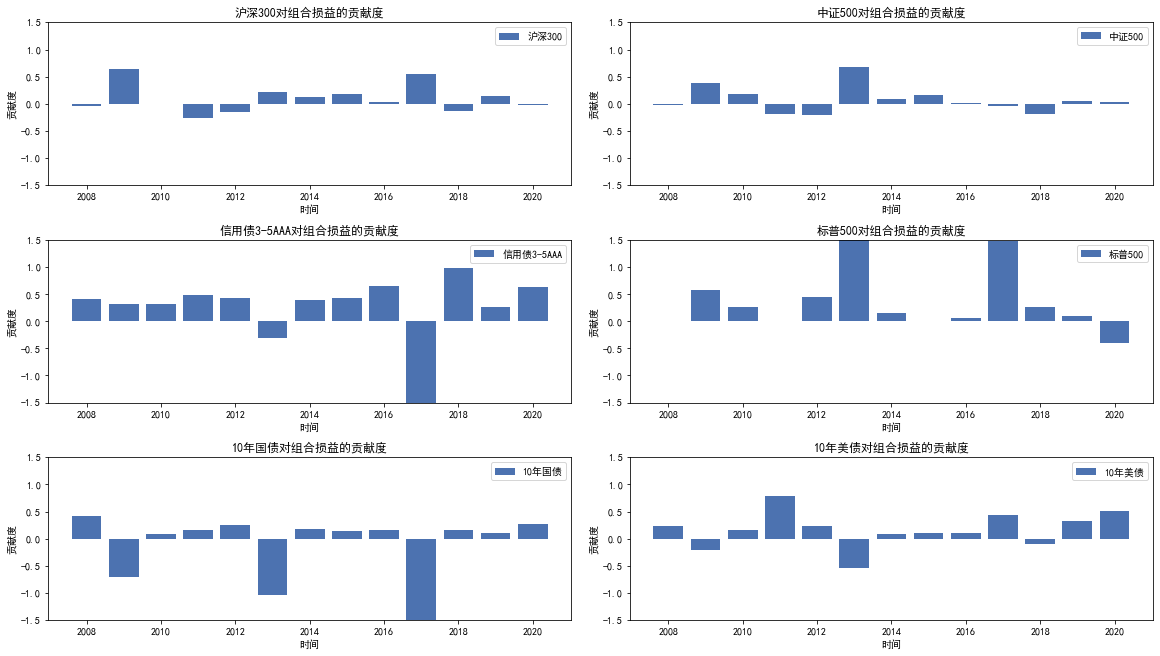

In [71]:
StatisticFunc.BarPlot(annualContrb_single, '模型E')

### 投资组合净值曲线

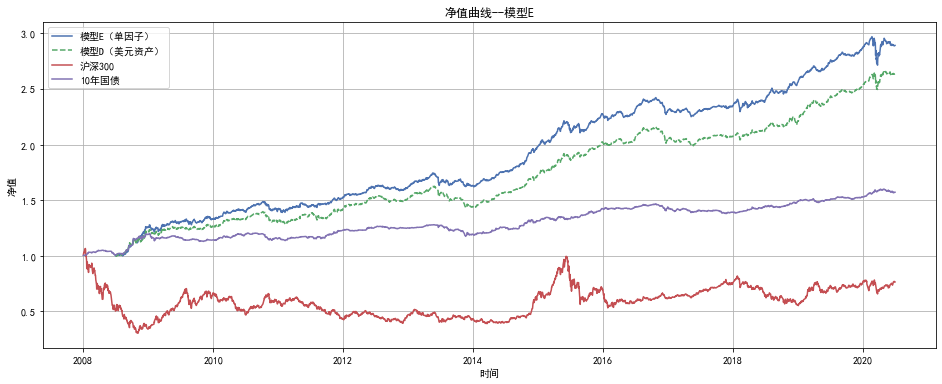

In [72]:
fig = plt.figure(figsize=(16, 6))

plt.plot(tradeDF_single.index, tradeDF_single['投资组合净值']/10000, label='模型E（单因子）')
    
plt.plot(tradeDF_D.index, tradeDF_D['投资组合净值']/10000, ls='--', label='模型D（美元资产）')  
plt.plot(cumReturns.index, cumReturns['沪深300'], label='沪深300')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('净值曲线--模型E')
plt.savefig('Pics/净值曲线_模型E.png')

## 模型F：多因子

- 横截面动量+时序动量+换手率+铜金+铜油+汇率

### 程序运行

In [73]:
thrds = {'Equity':0.50, 'FixedIncome':0.90, 'Commodity':0.30}
factors = {'momentumX':True, 'momentumT':False, 
            'reverseX':False, 'reverseT':False,
            'turnover':True, 'fxRate':True,
            'copperGold':True, 'copperGas':True}

tradeDF_multi, weightDF_multi = AlgoLoop.AlgoTrade(Assets, leverReturns_D, leverCumReturns_D, 
                                                   Turnovers, FXRates, mode='ema', dt=120, up=0.50, 
                                                   thresholds=thrds, factorDict=factors)

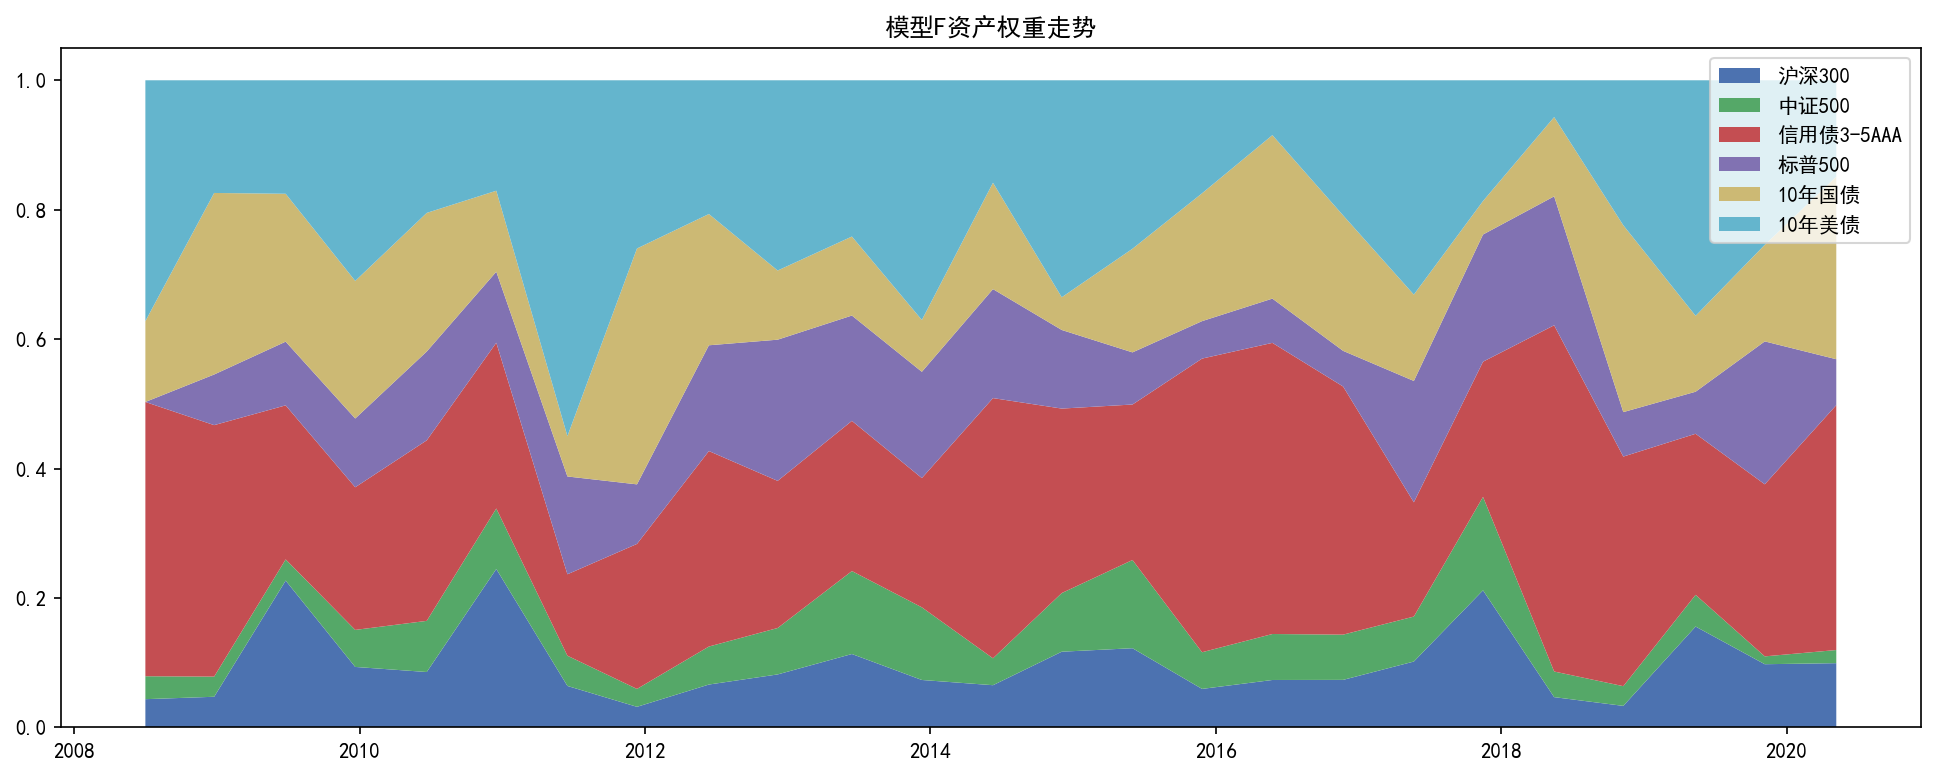

In [74]:
StatisticFunc.WeightPlot(tradeDF_multi, weightDF_multi, '模型F')

### 回测表现汇总

In [75]:
smryDF_multi = StatisticFunc.summaryDF(tradeDF_multi)
pfmcDF_multi = StatisticFunc.performanceDF(smryDF_multi, tradeDF_multi, name='模型F')

In [76]:
smryDF_multi

年收益率      年波动率       信息比      最大回撤
2008  0.220650  0.099124  2.225993 -0.033087
2009  0.076428  0.090758  0.842105 -0.065730
2010  0.079885  0.059805  1.335757 -0.063168
2011  0.027514  0.066178  0.415751 -0.074805
2012  0.049946  0.036020  1.386604 -0.033462
2013  0.048022  0.059679  0.804679 -0.071108
2014  0.183017  0.043173  4.239204 -0.065359
2015  0.184019  0.090302  2.037817 -0.094335
2016  0.076430  0.043061  1.774951 -0.073743
2017 -0.025471  0.033511 -0.760077 -0.090754
2018  0.055429  0.052180  1.062272 -0.080096
2019  0.117583  0.031590  3.722157 -0.025133
2020  0.062963  0.092210  0.682821 -0.071112

In [77]:
pfmcDF_multi

年化收益     年化波动率      最大回撤  最长不创新高时间       信息比  Calmar比率
模型F  0.088955  0.061353 -0.094335     438.0  1.449885  0.942972

### 收益率贡献度

In [78]:
annualContrb_multi = StatisticFunc.AnnualContribution(tradeDF_multi)

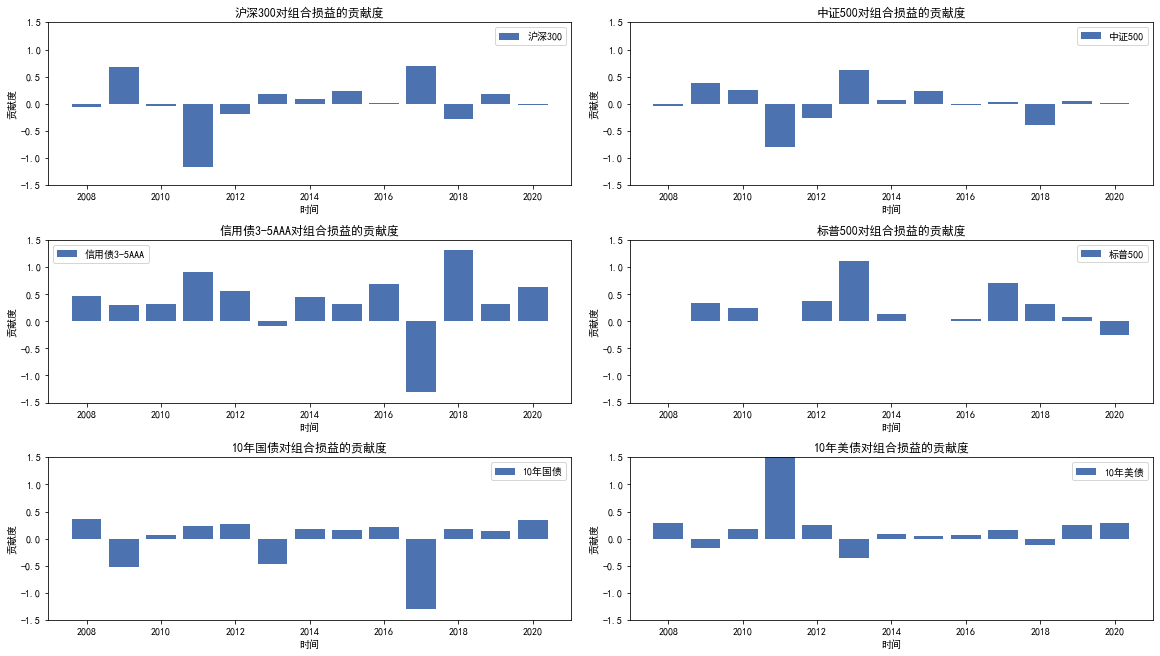

In [79]:
StatisticFunc.BarPlot(annualContrb_multi, '模型F')

### 投资组合净值曲线

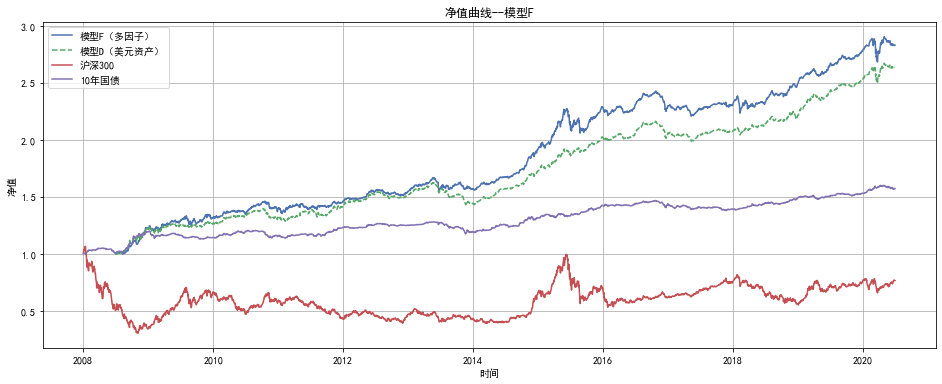

In [80]:
fig = plt.figure(figsize=(16, 6))

plt.plot(tradeDF_multi.index, tradeDF_multi['投资组合净值']/10000, label='模型F（多因子）')
    
plt.plot(tradeDF_D.index, tradeDF_D['投资组合净值']/10000, ls='--', label='模型D（美元资产）')  
plt.plot(cumReturns.index, cumReturns['沪深300'], label='沪深300')
plt.plot(cumReturns.index, cumReturns['10年国债'], label='10年国债')

plt.xlabel('时间')
plt.ylabel('净值')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('净值曲线--模型F')
plt.savefig('Pics/净值曲线_模型F.png')

# 模型结果对流动性的依赖

In [107]:
# 投资组合日收益率
PnL = tradeDF_single['投资组合净值'] / tradeDF_single['投资组合净值'].shift(1, axis=0) - 1.0
PnL = PnL.dropna()

## 二级市场流动性

- A股成交量、换手率
- 美股成交量、换手率

### 流动性数据

In [82]:
LiqData = pd.read_excel(io="Raw/二级市场流动性.xlsx")
LiqData.columns = LiqData.iloc[1, :]

In [83]:
Volume = LiqData.iloc[:, :4]
Volume = Volume.drop(index=[0, 1, 2])
Volume = Volume.set_index(['日期'])

In [84]:
Turnover = LiqData.iloc[:, 5:]
Turnover = Turnover.drop(index=[0, 1, 2])
Turnover = Turnover.set_index(['日期'])

### 相关系数

In [161]:
# 成交量相关系数
data1 = Volume.loc[PnL.index, '沪深300'].ewm(60).mean()
data2 = Volume.loc[PnL.index, '中证500'].ewm(60).mean()
data3 = PnL.ewm(60).mean()

np.corrcoef(data1, data3), np.corrcoef(data2, data3)

(array([[1.        , 0.05542451],
        [0.05542451, 1.        ]]),
 array([[ 1.        , -0.05957706],
        [-0.05957706,  1.        ]]))

In [162]:
# 换手率相关系数
data1 = Turnover.loc[PnL.index, '沪深300'].ewm(60).mean()
data2 = Turnover.loc[PnL.index, '中证500'].ewm(60).mean()
data3 = PnL.ewm(60).mean()

np.corrcoef(data1, data3), np.corrcoef(data2, data3)

(array([[1.        , 0.41768608],
        [0.41768608, 1.        ]]),
 array([[1.        , 0.25880396],
        [0.25880396, 1.        ]]))

### 流动性与投资组合表现

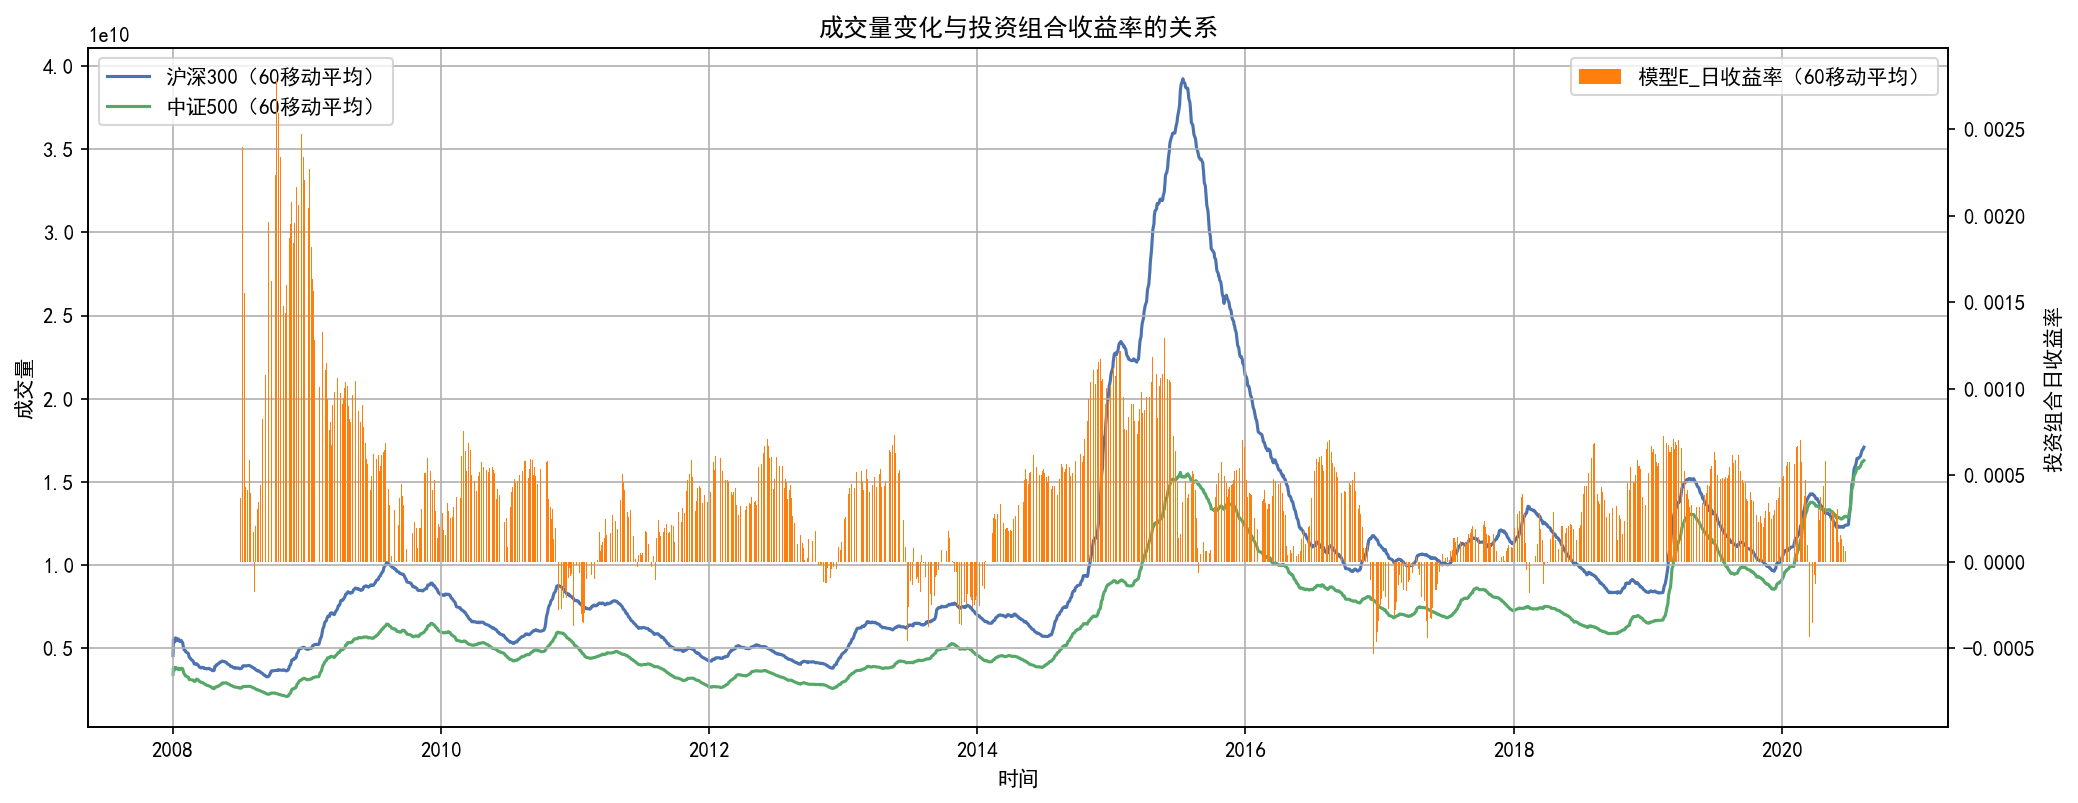

In [128]:
# 成交量
fig, ax1 = plt.subplots(1, 1, figsize=(16,6), dpi=150)

ax1.plot(Volume.index, Volume['沪深300'].ewm(60).mean(), label='沪深300（60移动平均）', zorder=0)
ax1.plot(Volume.index, Volume['中证500'].ewm(60).mean(), label='中证500（60移动平均）', zorder=1)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('成交量')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(60).mean(), label='模型E_日收益率（60移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合日收益率')

plt.title('成交量变化与投资组合收益率的关系')
plt.show()

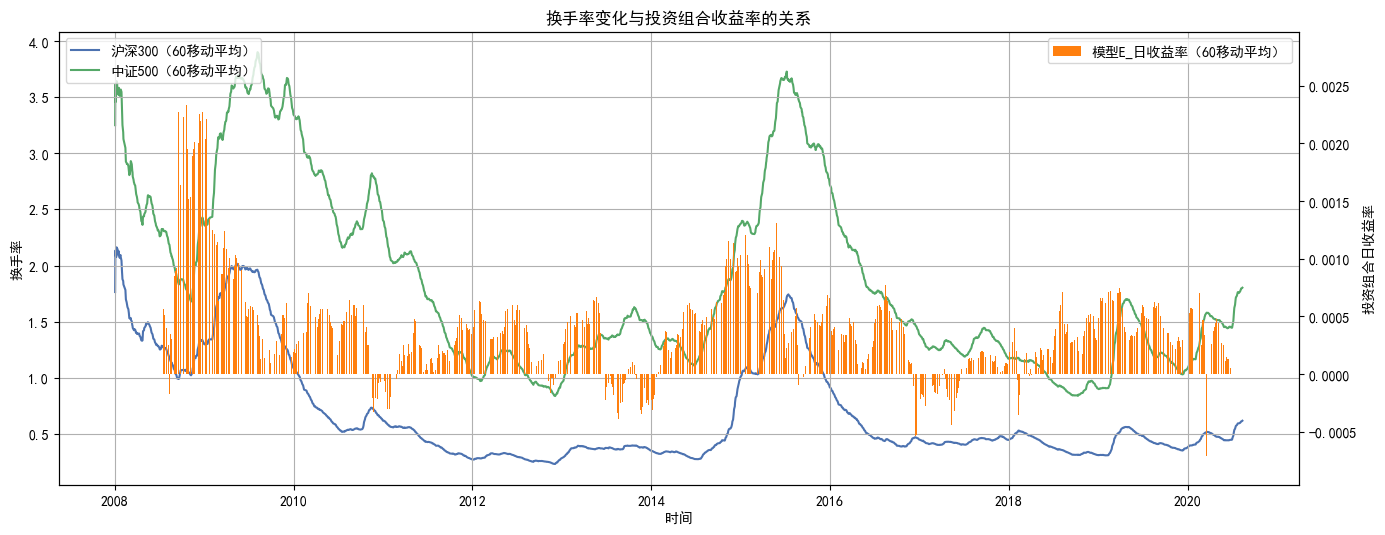

In [129]:
# 换手率
fig, ax1 = plt.subplots(1, 1, figsize=(16,6), dpi=100)

ax1.plot(Turnover.index, Turnover['沪深300'].ewm(60).mean(), label='沪深300（60移动平均）', zorder=1)
ax1.plot(Turnover.index, Turnover['中证500'].ewm(60).mean(), label='中证500（60移动平均）', zorder=0)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('换手率')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(60).mean(), label='模型E_日收益率（60移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合日收益率')

plt.title('换手率变化与投资组合收益率的关系')
plt.show()

## 广义信贷市场流动性

- 社会融资规模累计同比 - m2同比
- m2同比 - 名义GDP


### 流动性数据

In [89]:
# 基本处理
CredData = pd.read_excel(io='Raw/广义信贷市场流动性.xls')
CredData = CredData.drop([0, 3841, 3842], axis=0)
CredData.columns = ['日期', 'M2同比 - GDP同比', '10年美债收益率', 'M2同比', 'M1同比', 'M1同比 - M2同比', '社会融资规模同比 - M2同比']
CredData = CredData.set_index('日期')

# 用季度数据填充日数据
CredData = CredData.fillna(method='bfill', axis=0)

### 相关系数

In [109]:
# M2同比 - GDP同比 相关系数
data1 = CredData.loc[PnL.index, 'M2同比 - GDP同比'].ewm(20).mean()
data2 = PnL.ewm(20).mean()

np.corrcoef(data1, data2)

array([[1.        , 0.01714933],
       [0.01714933, 1.        ]])

In [110]:
# 社融规模 - M2同比 相关系数
data1 = CredData.loc[PnL.index, '社会融资规模同比 - M2同比'].ewm(20).mean()
data2 = PnL.ewm(20).mean()

np.corrcoef(data1, data2)

array([[ 1.        , -0.07445674],
       [-0.07445674,  1.        ]])

### 流动性与投资组合表现

/Users/trevor/anaconda3/envs/myTensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/trevor/anaconda3/envs/myTensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


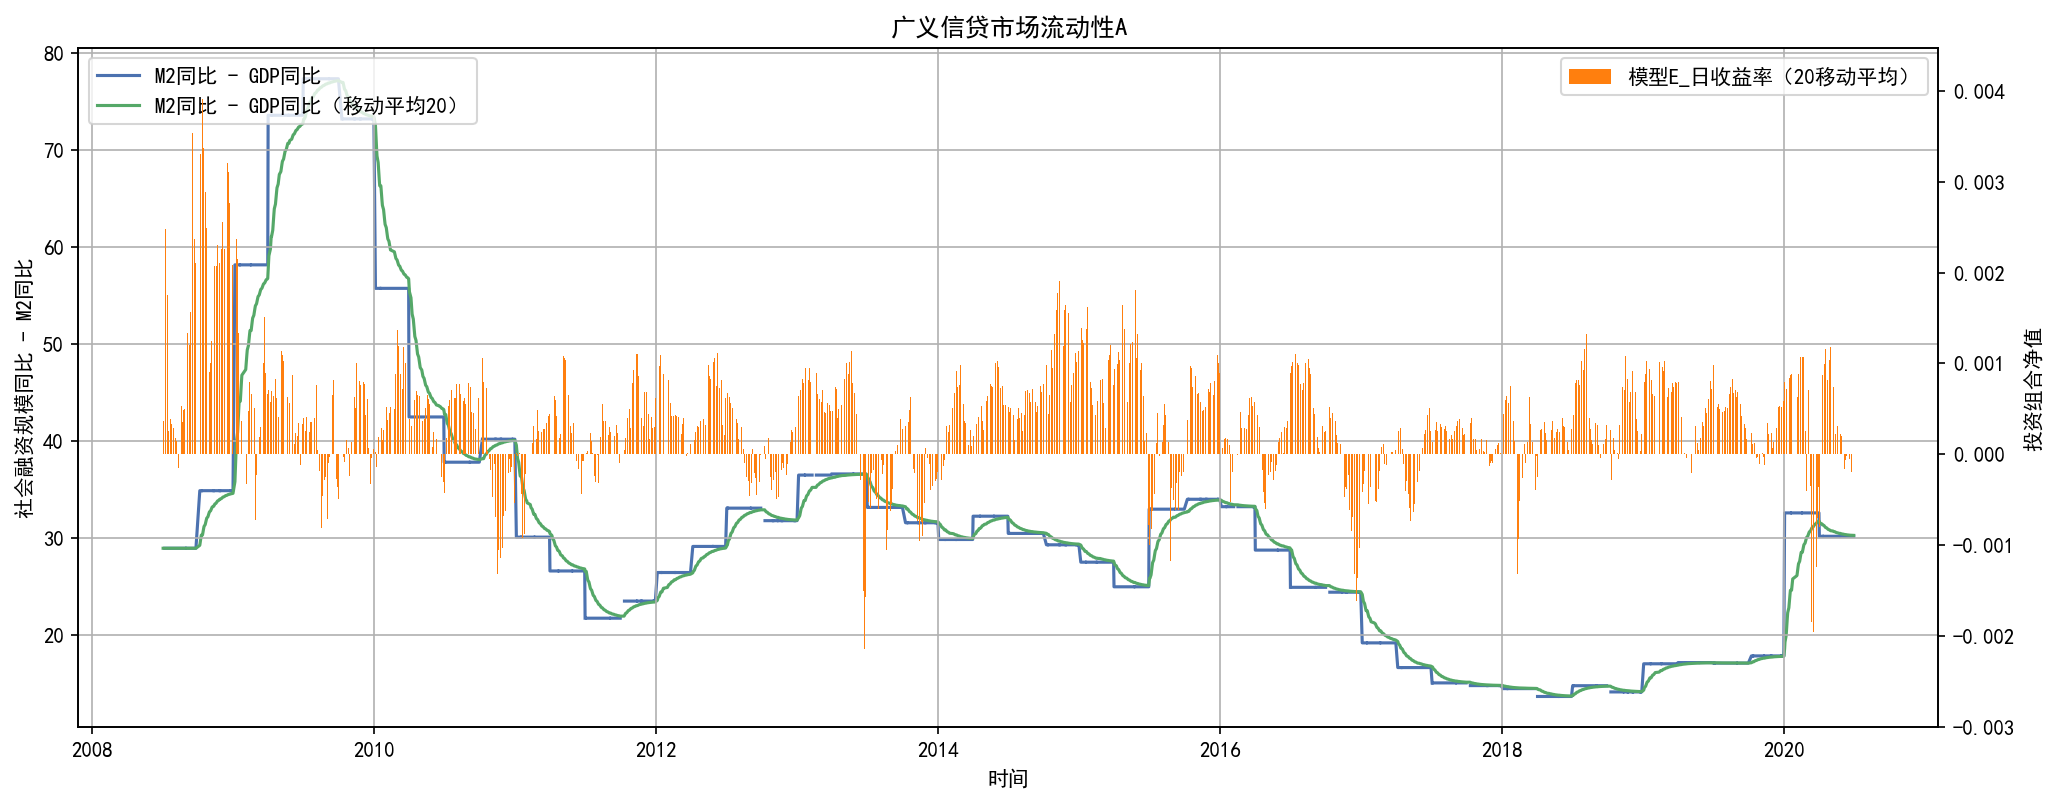

In [152]:
# M2同比 - GDP同比
fig, ax1 = plt.subplots(1,1,figsize=(16,6), dpi=150)

ax1.plot(PnL.index, CredData.loc[PnL.index, 'M2同比 - GDP同比'], 
         label='M2同比 - GDP同比', zorder=0)
ax1.plot(PnL.index, CredData.loc[PnL.index, 'M2同比 - GDP同比'].ewm(20).mean(), 
         label='M2同比 - GDP同比（移动平均20）', zorder=1)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('社会融资规模同比 - M2同比')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(20).mean(), label='模型E_日收益率（20移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合净值')

plt.title('广义信贷市场流动性A')
plt.show()

/Users/trevor/anaconda3/envs/myTensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/Users/trevor/anaconda3/envs/myTensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


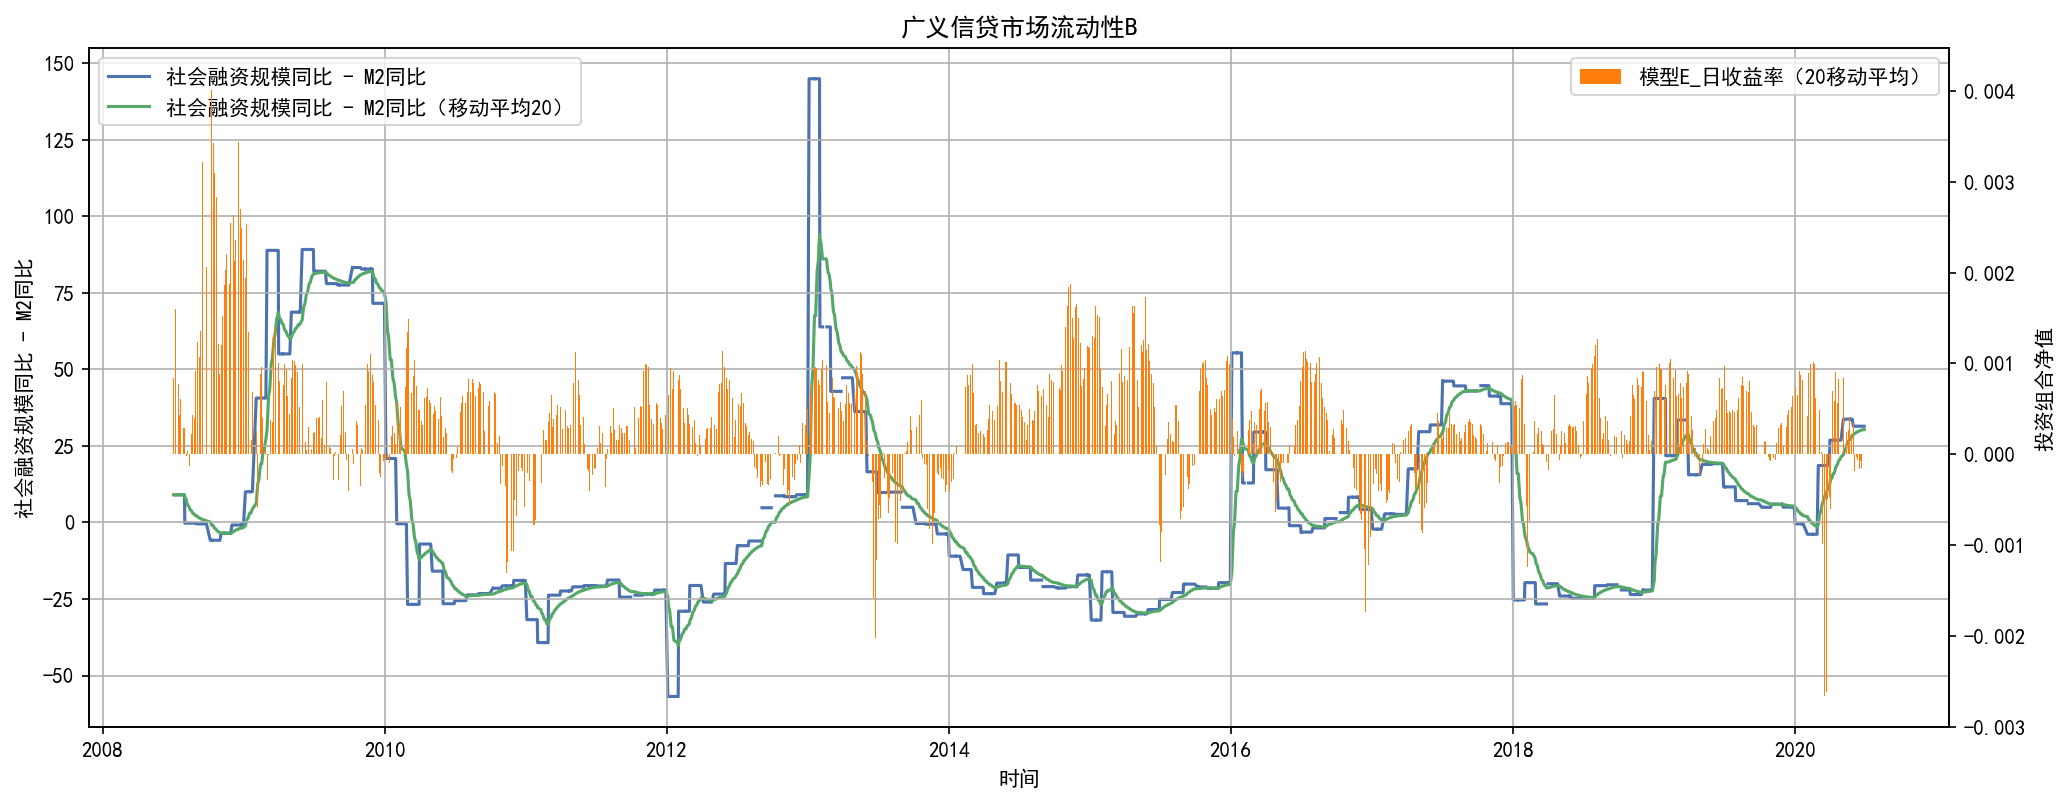

In [153]:
# 社会融资规模同比 - M2同比
fig, ax1 = plt.subplots(1,1,figsize=(16,6), dpi=150)

ax1.plot(PnL.index, CredData.loc[PnL.index, '社会融资规模同比 - M2同比'], 
         label='社会融资规模同比 - M2同比', zorder=0)
ax1.plot(PnL.index, CredData.loc[PnL.index, '社会融资规模同比 - M2同比'].ewm(20).mean(), 
         label='社会融资规模同比 - M2同比（移动平均20）', zorder=1)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('社会融资规模同比 - M2同比')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(20).mean(), label='模型E_日收益率（20移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合净值')

plt.title('广义信贷市场流动性B')
plt.show()

## 狭义金融市场流动性（利率）

- 超储率：超额存款准备金占存款的比例称为超额存款准备金率

<!-- - 货币市场利率：利率互换、同业存单、DR007

- 公开市场净投放：央行7天逆回购

- 美国市场利率：联邦基金利率、3M Libor、通胀保值债券（TIPS）利率 -->

- 10年国债收益率

- 10年美债收益率

- 美元指数

### 流动性数据

In [94]:
FinData = pd.read_excel(io='Raw/狭义金融市场流动性.xlsx')

# 整理表格
FinData.columns = FinData.iloc[1, :]
FinData = FinData.drop([0, 1, 2], axis=0)
FinData = FinData.set_index('日期')

# 填充Backfill  
FinData = FinData.fillna(method='ffill')

### 相关系数

In [146]:
# 超储率相关系数
data1 = FinData.loc[PnL.index, '超额存款准备金率(超储率):金融机构'].ewm(60).mean()
data2 = PnL.ewm(60).mean()

np.corrcoef(data1, data2)

/Users/trevor/anaconda3/envs/myTensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


array([[1.        , 0.27847976],
       [0.27847976, 1.        ]])

In [147]:
# 10年国债收益率
data1 = Returns.loc[PnL.index, '10年国债'].ewm(60).mean()
data2 = PnL.ewm(60).mean()

np.corrcoef(data1, data2)

array([[1.        , 0.80618147],
       [0.80618147, 1.        ]])

In [148]:
# 10年美债收益率
data1 = Returns.loc[PnL.index, '10年美债'].ewm(60).mean()
data2 = PnL.ewm(60).mean()

np.corrcoef(data1, data2)

array([[1.        , 0.49747305],
       [0.49747305, 1.        ]])

In [149]:
# 美元价格指数
data1 = FXRates.loc[PnL.index, '美元指数'].ewm(60).mean()
data2 = PnL.ewm(60).mean()

np.corrcoef(data1, data2)

array([[ 1.        , -0.15016538],
       [-0.15016538,  1.        ]])

### 流动性与投资组合表现

/Users/trevor/anaconda3/envs/myTensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


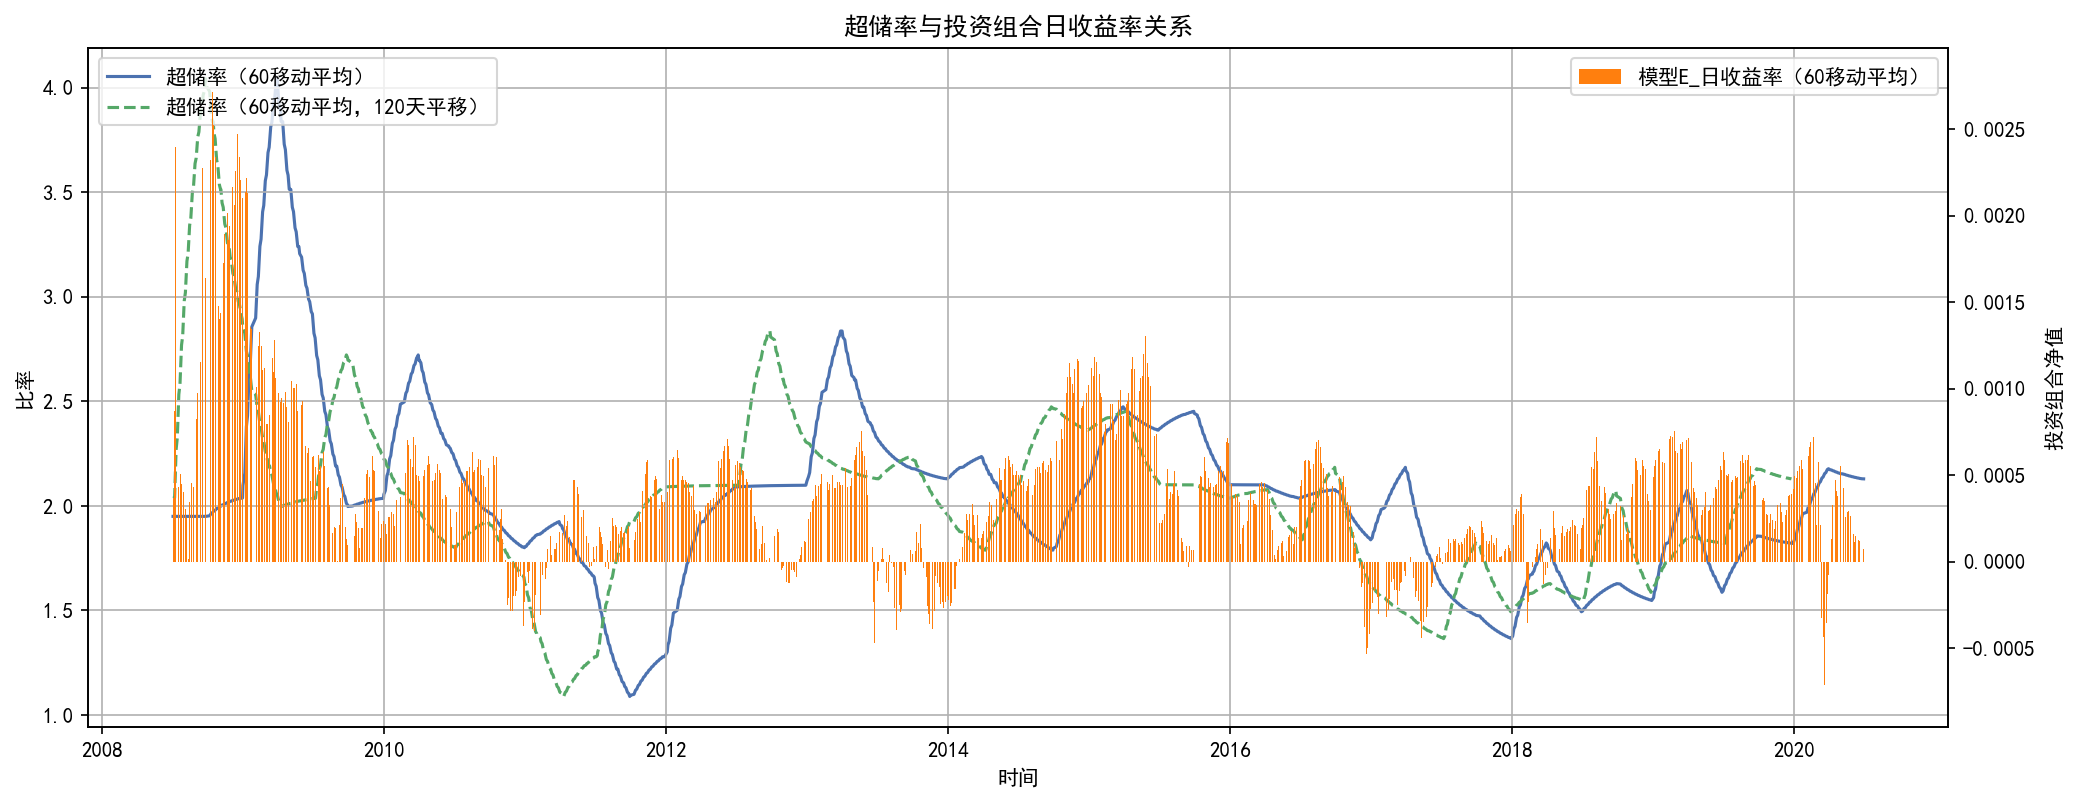

In [172]:
# 超储率
fig, ax1 = plt.subplots(1,1,figsize=(16,6), dpi=150)

data_tmp = FinData.loc[PnL.index, '超额存款准备金率(超储率):金融机构'].ewm(60).mean()

ax1.plot(data_tmp.index, data_tmp, label='超储率（60移动平均）', zorder=0)
ax1.plot(data_tmp.shift(-120).index, data_tmp.shift(-120), ls='--', label='超储率（60移动平均，120天平移）', zorder=1)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('比率')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(60).mean(), label='模型E_日收益率（60移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合净值')

plt.title('超储率与投资组合日收益率关系')
plt.show()

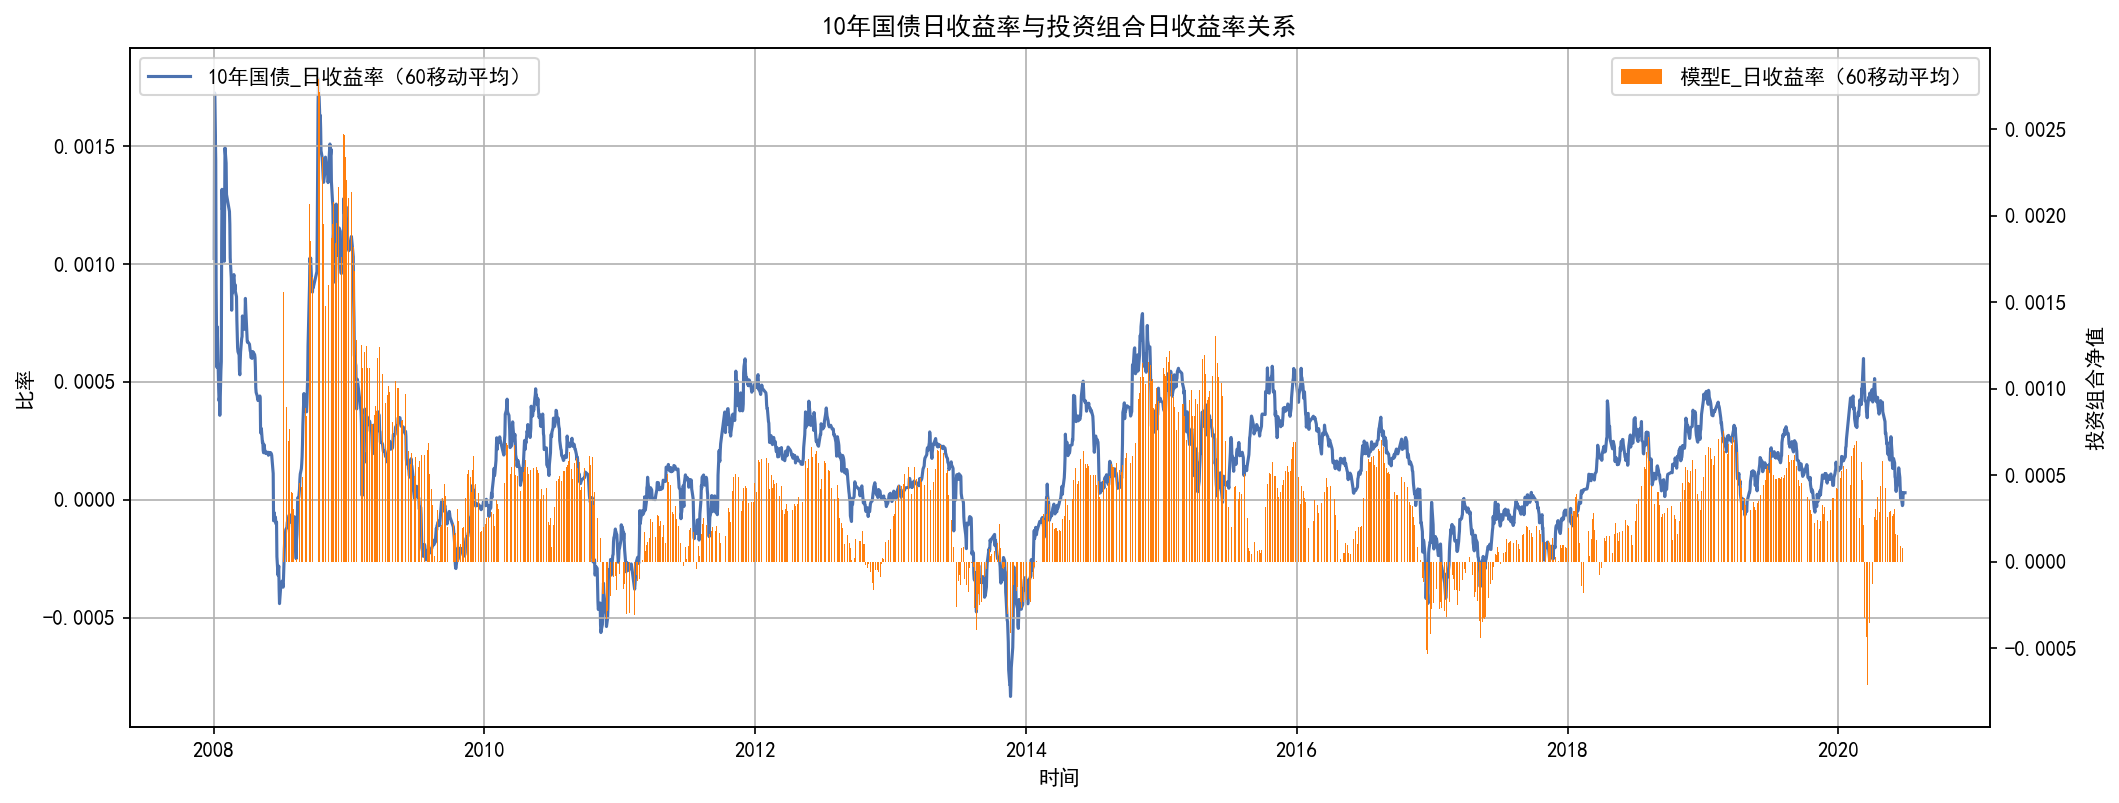

In [158]:
# 10年国债
fig, ax1 = plt.subplots(1,1,figsize=(16,6), dpi=150)

ax1.plot(Returns.index, Returns['10年国债'].ewm(60).mean(), label='10年国债_日收益率（60移动平均）', zorder=0)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('比率')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(60).mean(), label='模型E_日收益率（60移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合净值')

plt.title('10年国债日收益率与投资组合日收益率关系')
plt.show()

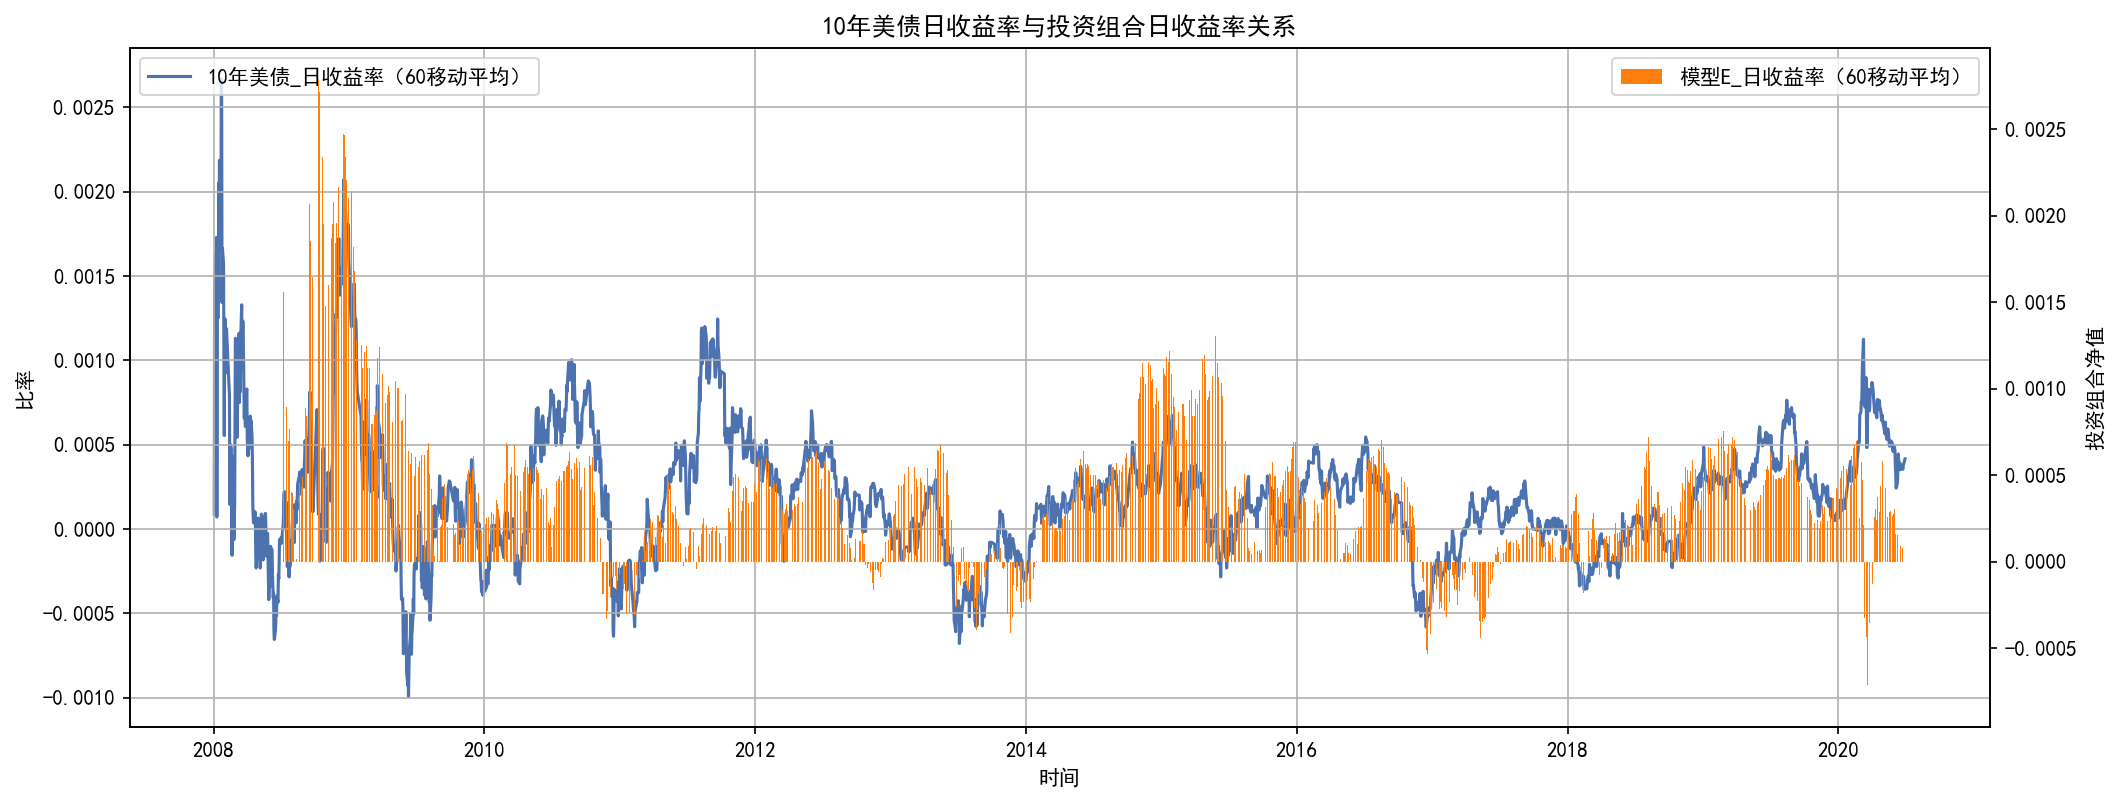

In [159]:
# 10年美债
fig, ax1 = plt.subplots(1,1,figsize=(16,6), dpi=150)

ax1.plot(Returns.index, Returns['10年美债'].ewm(60).mean(), label='10年美债_日收益率（60移动平均）', zorder=1)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('比率')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(60).mean(), label='模型E_日收益率（60移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合净值')

plt.title('10年美债日收益率与投资组合日收益率关系')
plt.show()

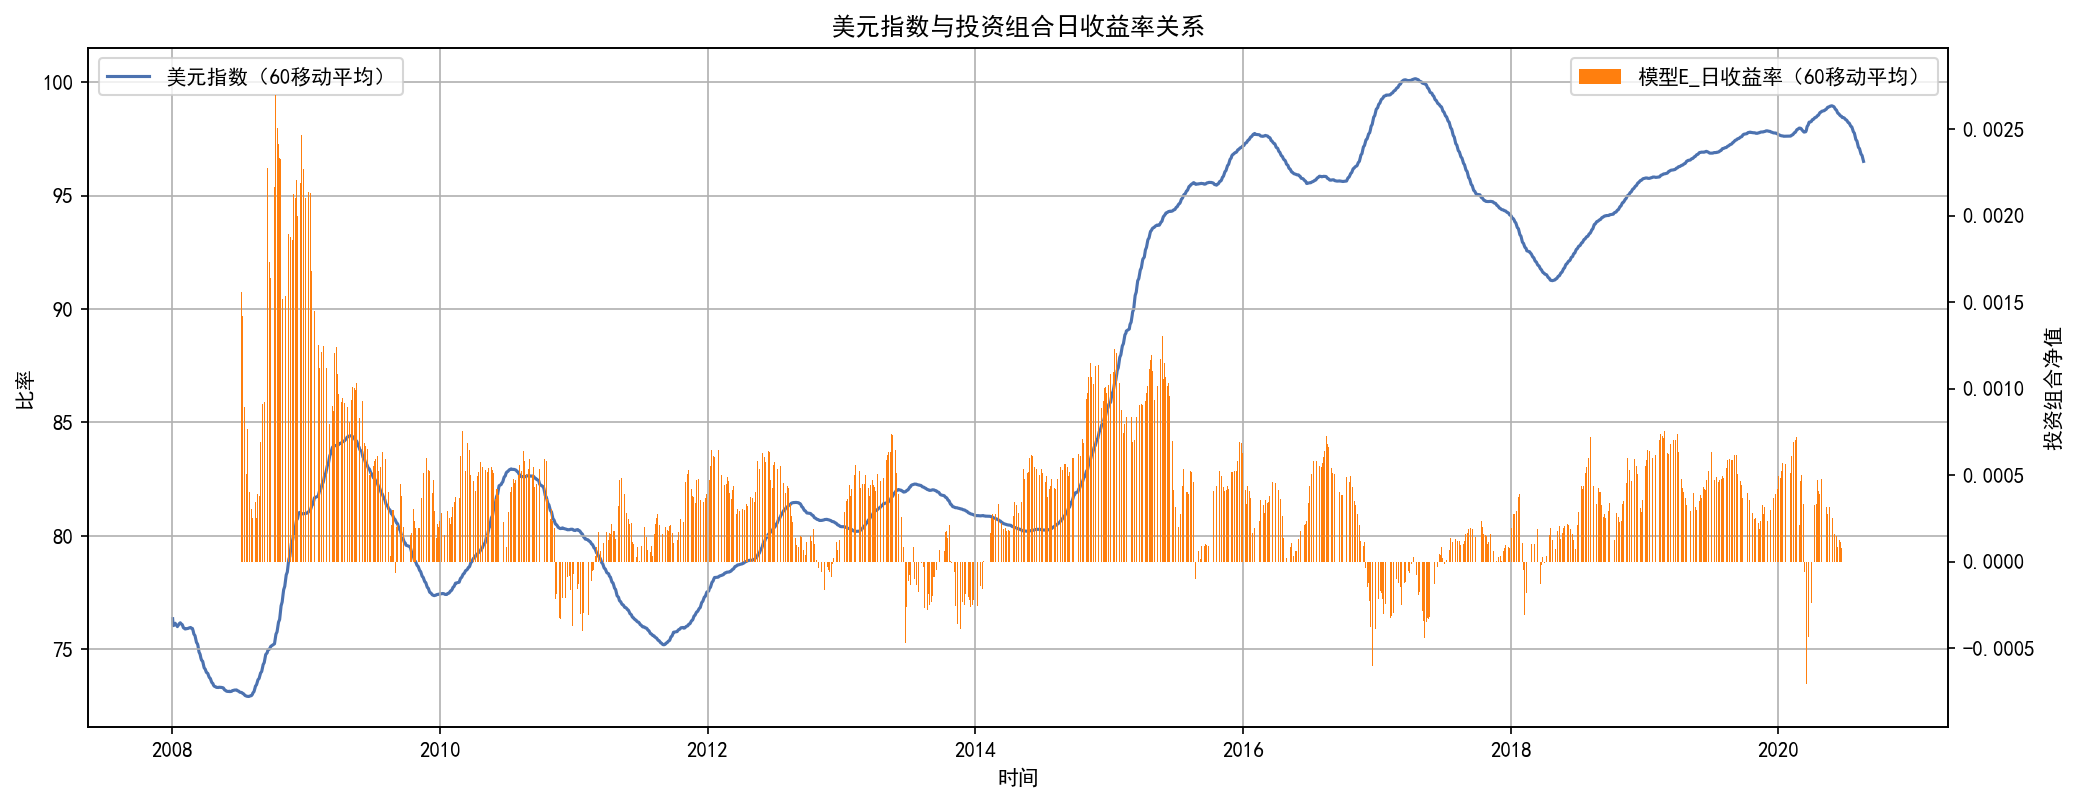

In [160]:
# 美元指数
fig, ax1 = plt.subplots(1,1,figsize=(16,6), dpi=150)

ax1.plot(FXRates.index, FXRates['美元指数'].ewm(60).mean(), label='美元指数（60移动平均）', zorder=1)

ax1.legend(loc='upper left')
ax1.set_xlabel('时间')
ax1.set_ylabel('比率')
ax1.grid(True)

ax2 = ax1.twinx()  
ax2.bar(PnL.index, PnL.ewm(60).mean(), label='模型E_日收益率（60移动平均）', color='tab:orange')

ax2.legend(loc='upper right')
ax2.set_ylabel('投资组合净值')

plt.title('美元指数与投资组合日收益率关系')
plt.show()